# Do Users Even Give a F...ont?
We've been hired by a startup company that sells food products, and we were tasked with studying user behaviour in the company's app. The company is interested in trying to boost its revenue by changing the app's fonts, but is concerned this might be an intimidating change that would actually cause the opposite effect. 

That's why an A/A/B test was called in. A certain amount of users has been picked, and users were split into three groups - two control groups, users of which were monitored while using the app having its current font set, and one test group, users of which were shown the new fonts. The test has been going on for some time, and now the company wants to know whether the new fonts were beneficial or did they have adverse effects. Or, maybe, neither?

Do users even "give a Font"?

# Outline of Analysis
The first thing we have done was to prepare the data for analysis. This included adding a few additional columns, changing data types, checking for duplicates, as well as trying to figure out what's the source of those duplicates, before deciding how to handle them.

Once this was done, we also checked whether all entries in the data are relevant. This was done by checking the dates from and until which the entries span, and, judging by the amount of entries in each date, we have determined the relevant time period to be analyzed, while discarding irrelevant entries from other periods. We also checked whether some of the users in the dataset belonged to more than group.

While this wasn't requested explicitly, we also checked for outliers in the data. We're dealing with users who perform actions on an app, which means some of them make a small amount of actions and some make a large amount of them. We checked for the distribution of number of actions per user, and tried to determine what could be considered a typical behaviour. However, at the initial stage of the analysis, we did not drop any users from the data, unless they didn't have any registered action during the relevant period, discussed above.

Once everything was ready, we proceeded to study the event funnel of the app. We did this two different ways - one, by studying the user behaviour of the entire population of the test, regardless of group. Two, we did the same for each of the groups individually, to enable us to compare the groups, at least on a basic level. Our event funnels showed two types of information - one type was focused on the number of occurences of each type of event of the app, and the other focused on the number and the percentage of *users* who went from one stage to the next, thus enabling us to determine retention rates, and see which step was the most problematic - the step in which we lose most users.

After all of that, we aggregated the data and performed a series of Z-tests - tests of proportion comparison - in order to see if there is any statistically significant difference between the groups. This included an A/A test, in which the two control groups were compared, in order to make sure the recruitment phase of the test went properly, so we could be sure our A/B test results were genuine, and not skewed by some error. We have compared all groups between themselves for every step of the action sequence in the app, and came to our final conclusion.

In order to further verify our results and conclusions, we have prepared a **filtered** dataset, excluding all the users deemed outliers in terms of number of actions. We re-made all the appropriate tables, and re-ran all of the Z-tests, to see if excluding the outliers made any difference at all.

Once we had all the test results, both with and without the outliers, we made our final conclusions, written at the very bottom of this report.

# Table of Contents
1. [Initialization](#Initialization)
2. [Preparing the Data for Analysis](#Preparing-the-Data-for-Analysis)
3. [Studying and Checking the Data](#Studying-and-Checking-the-Data)
4. [Studying the Event Funnel](#Studying-the-Event-Funnel)
5. [Interim Conclusions](#Interim-Conclusions)
6. [Checking User Sequences](#Checking-User-Sequences)
7. [Experiment Results](#Experiment-Results)
8. [Interim Conclusions (2)](#Interim-Conclusions-(2))
9. [Studying the Filtered Data, and Re-running the Tests](#Studying-the-Filtered-Data,-and-Re-running-the-Tests)
10. [Final Conclusions](#Final-Conclusions)

# Initialization

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from datetime import datetime
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_colwidth', None)

In [2]:
# loading the data

# note: we wanted to change the datatype of the `EventName` column to `category`, 
# since it can only take 5 values, but it actually caused some issues later.
logs_raw = pd.read_csv('logs_exp_us.csv', sep = '\t')

# renaming the columns to more friendly names.
logs_raw.columns = ['event_name', 'user_id', 'event_timestamp', 'group_id'] 

In [3]:
# checking basic info and datatypes
logs_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   group_id         244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


In [4]:
# first look at the data
logs_raw.sample(5)

,event_name,user_id,event_timestamp,group_id
139373,OffersScreenAppear,8016534965909266602,1564950333,247
191193,MainScreenAppear,3909945206876963575,1565090044,247
165705,OffersScreenAppear,3059176892016404589,1565019924,246
53433,CartScreenAppear,7543879591140518446,1564744256,246
236001,CartScreenAppear,8644931766545549368,1565194100,246


# Preparing the Data for Analysis
The data is loaded, column names are better now (originally they had no spaces and a mixture of upper and lowercase letters).

According to the `.info` output, there are no missing values. However, we still need to:

1) Verify that there are only three possible values for `group_id`, as sometimes mistakes can happen and other, irrelevant values may be recorded.

2) Verify that there are no users belonging to more than one group. If any such users are found, they ought to be removed completely.

3) Change the `event_timestamp` to a more informative-looking type, which includes date and exact time.

4) Check for duplicates, and if any are found - decide how to handle them.

5) Add an `event_date` column. It willshow only the date of the event, without the exact time.

Once we've done all of these, we will be ready to move on.

In [5]:
# verifying that `group_id` only takes the three possible values - 246, 247, and 248:
logs_raw['group_id'].unique()

array([246, 248, 247], dtype=int64)

Looks fine. No other kinds of "groups" have been recorded.

In [6]:
# verifying that no user belongs to more than one `group_id`:
logs_raw.groupby('user_id')['group_id'].nunique().reset_index().query('group_id > 1')

,user_id,group_id


So far, so good. The above query returned an empty dataframe, which means that not a single user has been mistakenly assigned to more than one group.

(This markdown cell and the next code-cell is for **practice only**. You can skip them!)

The above method will give us a dataframe with all users who belong in ANY two groups, in any combination, or all three groups.
This is useful, neat and easy to use, if this is our goal (and it is, in our case).

However, if we wanted to make a list of all the user id's in every group, and then look for users who belong in:

1) All three groups, or

2) A combination of two *specific* groups

Then we could do the following:

In [7]:
members_246 = logs_raw.query('group_id == 246')['user_id'].unique() # list of all user id's in group 246
members_247 = logs_raw.query('group_id == 247')['user_id'].unique() # list of all user id's in group 247
members_248 = logs_raw.query('group_id == 248')['user_id'].unique() # list of all user id's in group 248

# list of all user id's present in ALL THREE GROUPS
shared_all = list(set(members_246).intersection(members_247).intersection(members_248)) 

# list of all user id's present in both control groups, whether or not they also present in the test group
shared_control = list(set(members_246).intersection(members_247))                                                                

print ('Number of members in group 246:', len(members_246))
print ('Number of members in group 247:', len(members_247))
print ('Number of members in group 248:', len(members_248))
print ('Number of shared members in all groups:', len(shared_all))
print ('Number of shared members in control groups:', len(shared_control))

Number of members in group 246: 2489
Number of members in group 247: 2520
Number of members in group 248: 2542
Number of shared members in all groups: 0
Number of shared members in control groups: 0


In [8]:
# fixing the `event_timestamp` column to show real dates and times:
logs_raw['event_timestamp'] = logs_raw['event_timestamp'].apply(lambda x:datetime.fromtimestamp(x))

# an alternative method to achieve the same result, not requiring `datetime` or the lambda function:
# logs_raw['event_timestamp'] = pd.to_datetime(logs_raw['event_timestamp'], unit='s')

logs_raw.head()

,event_name,user_id,event_timestamp,group_id
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248


In [9]:
# checking for number of duplicated rows
logs_raw.duplicated().sum()

413

Out of 244126 entries, we have 413 duplicated ones. This is actually a very low amount (0.17% of all entries), thus removing them seems to make sense. However, before we do that, we should do something we don't usually do (and that's not a good thing) - we should investigate what "kind" of duplicates are these, and perhaps try to understand where they came from. Although right now there isn't anything we can do to actually "repair" the data (only remove the duplicated rows), these might be an information worth knowing, in order to prevent such cases from occuring again.

This is what we will do:
We will iterate through all the columns in the duplicated data (there are only four columns, thankfully), and will calculate in how many *unique values* we have duplicates. This is best explained by two examples: 

1) We know we have three `group id`'s - 246, 247, and 248. Do we have duplicates only for ONE group? two groups? all three groups? maybe we will find out that only one group had duplicates for some reason. 

2) We know we have 5 different kinds of `event_name`s. Does our duplicated data involve *all five* events, or just one? we could find, for instance, that all 413 duplicated entries take just one value in the `event_name` column - for example, `MainScreenAppear`? If so, this would mean that there are no duplicates whatsoever for any of the other four events types. That could give us some hint what the problem is, even if we can't solve it right now.

As for WHY do we have duplicates - there could be many reasons, and it's possible that we, specifically, don't / won't have the tools to pinpoint the exact reasons.

In [10]:
# creating a dataframe consisting of only the duplicated entries:
duplicated_data = logs_raw[logs_raw.duplicated()]
duplicated_data.sample(5)

,event_name,user_id,event_timestamp,group_id
97586,PaymentScreenSuccessful,3610536745613892312,2019-08-03 18:21:06,248
58579,MainScreenAppear,5613730186262378552,2019-08-02 16:33:53,248
100730,PaymentScreenSuccessful,2570971451355530886,2019-08-03 19:49:05,248
23040,CartScreenAppear,6175409940769721675,2019-08-01 17:09:06,246
235825,PaymentScreenSuccessful,877451560995731305,2019-08-07 19:04:47,247


In [11]:
# checking the amount of unique values which had duplicates, in each column:
for column in duplicated_data.columns:
    print('Amount of unique values in the', column,'column:', duplicated_data[column].nunique())

Amount of unique values in the event_name column: 5
Amount of unique values in the user_id column: 237
Amount of unique values in the event_timestamp column: 352
Amount of unique values in the group_id column: 3


This is what we understand:

1) The duplicated entries happen with all 5 types of events. It isn't unique to any one kind of event.

2) We have 237 different users with at least one duplicated values (we could have a maximum of 413 users, in which case each one would only have 1 duplicated entry).

3) We have 352 different timestamps in which duplicates have occured. This doesn't tell us too much, but it's quite extraordinary (or ominous?) that we don't have 413 unique timestamps here. What are the odds of two different duplicate entries having the EXACT same timestamp? not very high, **UNLESS** some duplicated entries are completely identical to each other, meaning a certain event, of a certain user, was recorded not just one extra time, but more. We will try find an example for that in a bit.

4) We have duplicated across all three groups. It's not just a problem of any one or two specific groups.

In [12]:
# finding the most prevalent timestamps in the duplicated data:
duplicated_data['event_timestamp'].value_counts().head(5)

2019-08-02 09:10:06    4
2019-08-01 16:20:40    4
2019-08-02 01:11:49    4
2019-08-02 01:11:53    4
2019-08-05 20:00:03    3
Name: event_timestamp, dtype: int64

In [13]:
# trying to find out if it's only a coincidence, or do some entries repeat themselves more than one time, 
# which would explain why we have less than 413 unique timestamps:

duplicated_data.query('event_timestamp == "2019-08-02 09:10:06"')

,event_name,user_id,event_timestamp,group_id
44077,PaymentScreenSuccessful,636437379427729086,2019-08-02 09:10:06,247
44078,PaymentScreenSuccessful,636437379427729086,2019-08-02 09:10:06,247
44079,PaymentScreenSuccessful,636437379427729086,2019-08-02 09:10:06,247
44080,PaymentScreenSuccessful,636437379427729086,2019-08-02 09:10:06,247


Right, now it makes more sense. We don't have 413 different timestamps because some operations (events) of specific users were registered not just one extra time, but up to four extra times, as the above example shows. Let's hope the customer in question didn't really pay for the same order four times...

We can check one more thing - were all the duplicated entries recorded on the same day, or different days? if so, how many? 

In [14]:
duplicated_data['event_timestamp'].dt.date.unique()

array([datetime.date(2019, 7, 30), datetime.date(2019, 8, 1),
       datetime.date(2019, 8, 2), datetime.date(2019, 8, 3),
       datetime.date(2019, 8, 4), datetime.date(2019, 8, 5),
       datetime.date(2019, 8, 6), datetime.date(2019, 8, 7)], dtype=object)

The word "DISASTER" has 8 letters in it, which is only fitting, given the fact that we now see that the duplicated entries come from **eight consecutive days!**

This means that whatever fault caused the duplicated entries, it didn't last for just 1 day, or just a few minutes. It lasted much longer than that...

Either way, now that we know our duplicated data is splattered all over 8 days, 5 event types, 237 users and all 3 groups - we can only say it wasn't due to some random, short-lived fault in the data collection process. It was something bigger than that, but it isn't in our power to fix it now.

Our only consolation is that we are talking about a very minor part of the data - roughly 0.17% of all entries. It could have been much worse.
Naturally, we will remove all duplicated rows soon, keeping only one instance of each of the duplicated entries, and report our findings to our superiors. This should not have happened!

In [15]:
# adding the `event_date` and `event_time` columns:
logs_raw['event_date'] = logs_raw['event_timestamp'].astype('datetime64[D]')

logs_raw.sample(3)

,event_name,user_id,event_timestamp,group_id,event_date
185211,MainScreenAppear,2682464059584798653,2019-08-06 11:09:46,248,2019-08-06
65847,OffersScreenAppear,1456479928857490458,2019-08-02 19:32:51,247,2019-08-02
114157,MainScreenAppear,8810941885921686538,2019-08-04 11:14:05,247,2019-08-04


In [16]:
logs_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   group_id         244126 non-null  int64         
 4   event_date       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 24.8 MB


We will now remove the duplicated entries from the data, but our investigation is still incomplete. We still need to check for a few more things before we can call our data "clean".

**Please note**, we are removing only those 413 entries which are *full* duplicates, meaning, they match other entries before them entirely. One might argue that we should remove all entries which share the same values in only *some* of the columns (a subset). For example, we could decide to remove all entries in which the values of `user_id` AND `event_timestamp` are exactly the same, even if the value in the `event_name` is *different*. This means that if we have entries which share the same values in only these two columns (probably the most critical ones) - they will be removed, even if they are not "full" duplicates.
Some might call these cases *implicit duplicates*, rather than *explicit* ones.

The reasoning behind this approach would be that there is not a very good chance that a given user would be able to perform two actions (have two *different* events) at the same *exact* timestamp (literally at the same second).

On the other hand, there is also not a very high chance the same user would be able to perform two different actions - or even the same action - just one second apart (unless they're very VERY fast, or it's some kind of error), and there's always a chance the same event was registered twice (or more) in the data, seconds apart (thus having a slightly different timestamp). These scenarios can be considered as implicit duplicates too, which we are not removing (because we can't spot them using our code). 

In conclusion - though it would be reasonable to remove all entries which share the same values in only the `user_id` and `event_timestamp` columns - we won't do it right now, as we cannot be sure if those entries really are duplicates (although implicit), or genuine values. Thankfully, should it be requested, we can simply add the `subset = ['user_id', 'event_timestamp']` argument in the `drop_duplicates()` function below.

In [17]:
# removing duplicated rows from the data
logs_raw = logs_raw.drop_duplicates().reset_index(drop = True)
logs_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   group_id         243713 non-null  int64         
 4   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 24.7 MB


# Studying and Checking the Data
We already know that there are 5 types of events in our data. We also know that we have two control groups and one test group, and no user has been accidently assigned to more than one group. Now we will check for the following things:

1) How many users do we have, and how many users each group has. We wish to see the distribution between the three groups is more or less equal.

2) What is the average amount of events per user; We might also check if there are any outliers - users with too many or too few events. We will not remove these users from the data just YET, but we might do it later.

3) The date-coverage of the data. We will find the minimum and maxium dates, plot an histogram showing the *amount of events* per date (or a period of dates), and try to assess what is the relevant period for our analysis (we expect to find a period of time in which we have a lot of entries, more-or-less equally distributed). It could be that some users have some of their older actions/events - unrelated to our A/A/B test - recorded in the data, due to technical reasons, and those events will have to be removed, as they might skew our data and sabotage the analysis.

4) Should we need to remove some portion of the data due to the reason in number (3) above, we will check how many events (entries) were lost, how many users we lost (if any).

In [18]:
# checking the amount of unique users
print ('Total number of users in the raw data:', logs_raw['user_id'].nunique())

Total number of users in the raw data: 7551


In [19]:
# checking how many users there are in each group:
print ('Number of members in group 246:', logs_raw.query('group_id == 246')['user_id'].nunique())
print ('Number of members in group 247:', logs_raw.query('group_id == 247')['user_id'].nunique())
print ('Number of members in group 248:', logs_raw.query('group_id == 248')['user_id'].nunique())


Number of members in group 246: 2489
Number of members in group 247: 2520
Number of members in group 248: 2542


We have a total of 7,551 users, distributed reasonaly equally between all three groups - roughly 2,500 users in each.

In [20]:
# checking the average amount of events per users
user_events = logs_raw.groupby('user_id').agg(
    number_of_events = ('event_name' , 'count')
).reset_index()

print ('Average number of events per user:', round(user_events['number_of_events'].mean()))
# since the number of events is discrete (can't have 0.17 of an event), we rounded the mean to the nearest integer.

print ('Median number of events per user:', round(user_events['number_of_events'].median()))
# this time we used `round` just in order to have no decimals in the output.

Average number of events per user: 32
Median number of events per user: 20


The average and median number of events are quite far apart. This might suggest we have some outliers in the data. Be that as it may (and we will check it) - this in itself doesn't tell us much. Those 20, 32, or 106 events a user has - what does it mean? what if it's just the same user "refreshing" the app and seeing the main screen tens of times (not necessarily willingly, but due to some network problem)? we should be more interested not only in how many actions/events a given user has, but also WHAT those events are.

Instead of an average/median number of events per user, it will be more informative to look up how many users have only one recorded type of event in the data, how many have 2 types, and so on:

NOTE: we will re-create the `user_events` dataframe by copying the code above, but add an additional column with the required information.

In [21]:
user_events = logs_raw.groupby('user_id').agg(
    number_of_events = ('event_name' , 'count'),
    unique_events = ('event_name', 'nunique')
).reset_index()

user_events['unique_events'].value_counts().sort_index(ascending = False)

5     471
4    3035
3     317
2    1021
1    2707
Name: unique_events, dtype: int64

That's more informative, and this is what we learn. We have:

Only 471 users with records of all 5 events;
3035 users with records of 4 events;
317 users with 3 events;
1021 users with 2 events;
and 2707 with only 1 event.

Two things we should note:

1) Unless it was set up otherwise, we assume that the `tutorial` step is NOT something a given user has to go through (if, for example, it isn't part of the registration process, users can simply elect not to do it). This means that a given user with 4 events in his logs can be considered a user who went through all four "real" events - main screen -> offer page -> cart page -> order success page. HOWEVER, this is where the next point comes:

2) When we say a given user has records of 1-4 events, we don't know - at least not now - the COMBINATION of events of each user. What is the single event all those 2707 users with only 1 event went through? did they all just looked at the main screen? or maybe some of them did the tutorial, some watched the main screen, and some others - somehow - jumped directly to the offers page?

What we can do to see it, is to add yet another column to the dataframe above - a column which shows which type of events each user went through, at least once:

Once again we will re-create the `user_events` dataframe, and add the latter column (why isn't there a more convenient way to do it?!).
While we are at it - we will also add each user's group (this will be useful soon).

In [22]:
user_events = logs_raw.groupby('user_id').agg(
    group_id = ('group_id', 'unique'),
    number_of_events = ('event_name' , 'count'),
    unique_events = ('event_name', 'nunique'),
    event_types = ('event_name', 'unique')
).reset_index()

user_events['group_id'] = user_events['group_id'].astype('int64')

user_events[user_events['unique_events']==1]['event_types'].value_counts()

[MainScreenAppear]      2693
[OffersScreenAppear]      10
[Tutorial]                 4
Name: event_types, dtype: int64

As we can see, those who have only one event type in the logs do NOT necessarily have the SAME event. This means that those who have two events - can have *any combination* two events. Those with three and four events - same. Though this is very regretful (and maybe complicates things a bit), it tells us something important: there is NOT a single sequence of events through which users are going. Some users can, for example, go straight to an offers page without first viewing the main screen (possibly by use of a link, for example?). Whatever the reason is, we must keep this in mind.

Just so we don't get lost, here's a quick recap of what we have found so far:

1) The average and median number of events per user - 32 and 20, respectively. These numbers don't tell us much except that there might be some outliers in the data (something we will check next).

2) We found how many users had how many different kind of events in the logs. We saw that slightly less than half of the users (around 3500) had records of 4 or 5 different events (and we assume a good deal of those with 4 events skipped the tutorial, and went through all the really important events, though this is just an assumption at this stage). Roughly 18% others had only 2 or 3 different steps, which could be of any combination, and roughly 36% of users only had a single event logged in the data - almost all of them only saw the main screen, but a few others only went through the tutorial or viewed an offers page.

Now we are going to check for the distribution of amount of events per user. We want to find outliers in the data - both users with too many events and users with too few ones. At this stage, this will be for study purposes only. Later we might decide to remove them and study the behaviour of typical users only.

We will use a boxplot for this purpose. We want to see what is the typical range of number of events we have, as well as the "whisker" values. After that, we will also check for the 1st, 5th, 10th, 90th, 95th, and 99th percentile values. For both purposes, we will use the `user_events` table.

We'll start with the general distribution (without distinguishing between the groups), and then see how things look for each group separately.

In [ ]:
pio.templates.default = "plotly_dark" # setting the plotly theme to dark.

fig = px.box(user_events, y="number_of_events", title = 'Number of Events Distribution (Boxplot)', 
             color_discrete_sequence=px.colors.qualitative.Dark2)

fig.update_yaxes(title = 'Number of Events')

![Plot%201%20%28Number%20of%20Events%20Distribution%20(boxplot%29).png](attachment:Plot%201%20%28Number%20of%20Events%20Distribution%20(boxplot%29).png)
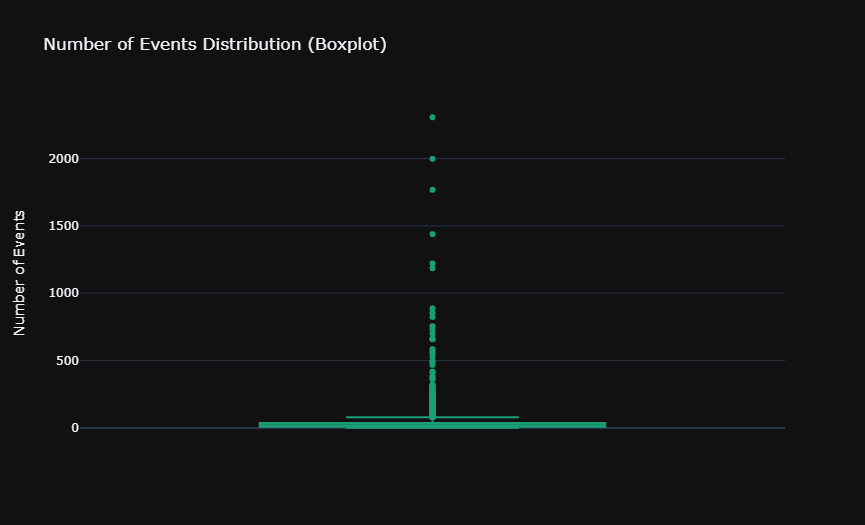

Zoomed-in:

![Plot%201.2%20%28Number%20of%20Events%20Distribution%20(boxplot%29).png](attachment:Plot%201.2%20%28Number%20of%20Events%20Distribution%20(boxplot%29).png)
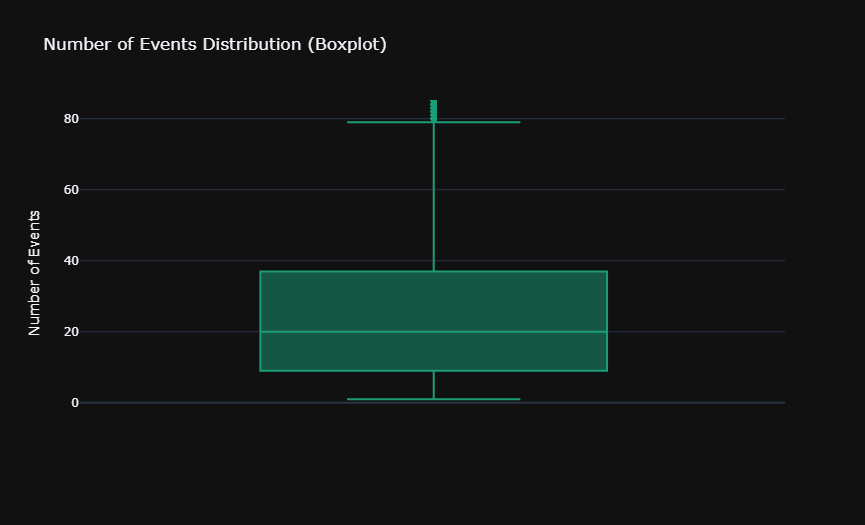

We can barely see the boxplot itself, as we have some very big outliers. Thankfully, the above figure is interactive, so we can simply zoom in and see the picture without all the outliers interfering. That also saves us time and code for calculation they key values. These are the values we get:

Q1 (25th percentile) = 9 events.

Q2 (median) = 20 events (as we already know).

Q3 (75th percentile) = 37 events.

Top whisker cap = 79 events.

Also, the minimum and maximum values are 1 and 2307(!), respectively. 

According to these values, we can define/decide that any user with *80 events* or more - is considered an outlier.

Let's calculate some more numbers (percentiles), for reference:

In [24]:
print ('1st, 5th, 10th, 90th, 95th and 99th percentile values (in that order):')
np.percentile(user_events['number_of_events'], [1, 5, 10, 90, 95, 99])

1st, 5th, 10th, 90th, 95th and 99th percentile values (in that order):


array([  1. ,   3. ,   5. ,  64. ,  89. , 200.5])

The above numbers can give us another option to define outliers, if we'll want to. We can, for example, define that all users above the 95th percentile - meaning, users with 90 events or more - are outliers.

Let's calculate how many users - out of our 7551 - are outliers:

In [25]:
# number of users above the top whisker cap (more than 79 events):
print ('Number of users with 80 events or more:', len(user_events.query('number_of_events > 79')))
# number of users above the 95th percentile:
print ('Number of users above the 95th percentile:', len(
    user_events[user_events['number_of_events'] > (np.percentile(user_events['number_of_events'], 95))]))

Number of users with 80 events or more: 494
Number of users above the 95th percentile: 372


It's no surprise that 4.9% of the users are above the 95th percentile (that's the whole point of *percentiles*...), but we can also say that only 6.5% of users are above the boxplot boundaries (as they have more than 79 events). 

Without getting ahead of ourselves, what we might do later is study the data both with and without those unusual users, and see if the results change.

For now, though, let's see the *percentage of events* (entries) our outliers are responsible to (in both options)

In [26]:
print ('Percentage of events by users with more than 79 events each: {:.2%}'.format(
    user_events.query('number_of_events > 79')['number_of_events'].sum() / len(logs_raw)))

print ('Percentage of events by users above the 95th percentile: {:.2%}'.format(
    user_events[user_events['number_of_events'] > 
                (np.percentile(user_events['number_of_events'], 95))]['number_of_events'].sum() / 
    len(logs_raw)))

Percentage of events by users with more than 79 events each: 33.35%
Percentage of events by users above the 95th percentile: 29.12%


6.5% percent of the users are responsible for a third of the data. That's quite a lot!
Also, if we consider only those 4.9% of users above the 95th percentile - the number isn't too different - almost 30% of the data belongs to them.

It's good that we know all of this, but for now no further actions are required. Later on, though, we might use this information to filter the data.

**One last remark, however:** 

All of the numbers above are correct for our **RAW** data (minus the duplicated entries). We still haven't checked the *dates* our data spans, but simply assumed that all entries are valid in terms of dates. This is what we are going to check next. We might come to the conclusion that some of our entries belong to irrelevant dates (before the A/A/B test began), in which case, should we want to remove outliers, we will have to run the above code AGAIN (thankfully it's not too much), and see how the figures change. They may not change by much, but it will be safe to double-check. Either way, outliers will be removed only after our data has been otherwise cleaned.

(In retrospect, it might have been a better idea to first check for the dates, and only THEN check for outliers...)

Let us now see what are the **dates** our data spans from and until:

In [27]:
print ('Earliest record:', logs_raw['event_date'].min())
print ('Latest record:', logs_raw['event_date'].max())

Earliest record: 2019-07-25 00:00:00
Latest record: 2019-08-08 00:00:00


We have data spanning from July 25th, 2019, until August 8th, 2019. But, we need to make sure all of our entries belong to the time period of the A/A/B test, as some records could have found their way into our data by some error.

We will plot a histogram showing the amount of events (entries) per day:

In [ ]:
fig = px.histogram(logs_raw, x="event_date", title = 'Number of Logged Events per Day', 
                   color_discrete_sequence= ['green'])

fig.update_layout(bargap=0.05)

fig.update_xaxes(title = 'Date')
fig.update_yaxes(title = 'Number of Logged Events')

fig.show()

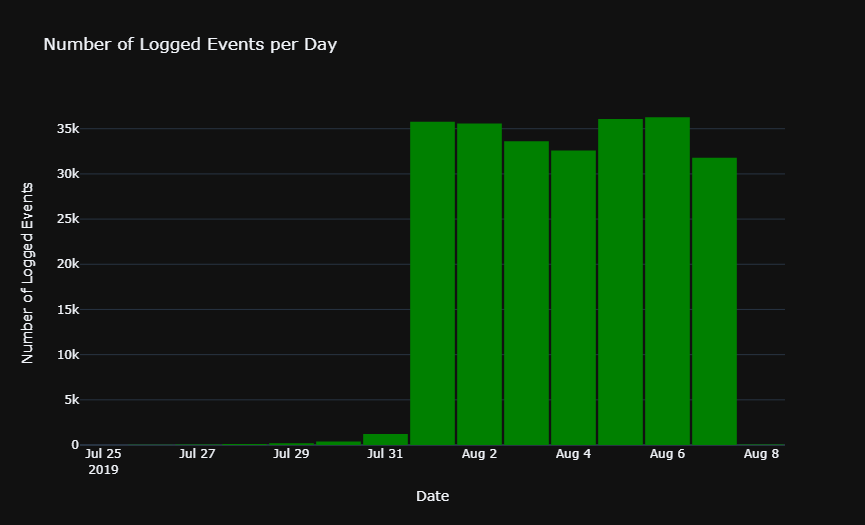

Quite obviously, out of the 15 days in our data, only the first week of August is relevant, as most of the events were logged during those days. Any event logged in before that might be due to some technical error. We will simply remove all entries from before August 1st, and after August 7th - since August 8th, even if it is part of the test, has only 68 entries, possibly from the first minutes of the day. Compared to the week preceding it, we can't say we have full data for that date, so we will remove it too. Thus, we will focus our analysis only on the first week of August.

Let's check how many entries we have in the dates to be excluded:

In [29]:
print ('Amount of irrelevant entries:', len(logs_raw.query(
    'event_date < "2019-08-01" or event_date > "2019-08-7"')))
print ('Percentage of irrelevant entries: {:.2%}'.format(len(
    logs_raw.query('event_date < "2019-08-01" or event_date > "2019-08-7"')) / len(logs_raw)))

Amount of irrelevant entries: 2057
Percentage of irrelevant entries: 0.84%


Out of the entire data, 2057 entries are irrelevant, and they constitue less than 1% of our data. That's not a lot, and we can remove them without too much pain.

---
**Therefore, we will now clean up the data as follows:** 

(Reminder - we have already removed the duplicated entries)

1) Remove all entries but those of the first week of August.

2) Re-check our outlier definitions, as these might change slighly due to the removal of the dates. We will have to re-run some of our code above in the following cells.

3) LATER ON, after we study the data with all the users, we will remove the outliers as we see fit, and then see how the results change, if at all.

We will rename the clean data simply as `logs`.

In [30]:
# creating the new dataframe, and starting by removing all irrelevant dates:
logs = logs_raw.query('event_date >= "2019-08-01" and event_date < "2019-08-8"').reset_index(drop = True)
logs.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241656 entries, 0 to 241655
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       241656 non-null  object        
 1   user_id          241656 non-null  int64         
 2   event_timestamp  241656 non-null  datetime64[ns]
 3   group_id         241656 non-null  int64         
 4   event_date       241656 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 24.5 MB


In [31]:
# checking how many users we still have:
logs['user_id'].nunique()

7538

Only 13 users were eliminated, as they did not appear in the relevant period.

In [32]:
# checking for outliers. This requires us to re-use some of the code above.

In [33]:
relevant_user_events = logs.groupby('user_id').agg(
    number_of_events = ('event_name' , 'count')
).reset_index()

print ('Average number of events per user:', round(relevant_user_events['number_of_events'].mean()))
# since the number of events is discrete (can't have 0.17 of an event), 
# we rounded the mean to the nearest integer.

print ('Median number of events per user:', round(relevant_user_events['number_of_events'].median()))
# this time we used `round` just in order to have no decimals in the output.

Average number of events per user: 32
Median number of events per user: 19


The average number of events per user hasn't changed. The median number decreased by 1.

In [ ]:
# checking the distribution:
fig = px.box(relevant_user_events, y="number_of_events",
             title = 'Number of Events Distribution (Boxplot), Relevant Dates', 
             color_discrete_sequence=px.colors.qualitative.Dark2)

fig.update_yaxes(title = 'Number of Events')

![Plot%203%20%28Number%20of%20Events%20Distribution%20(boxplot%29,%20Relevant%20Dates).png](attachment:Plot%203%20%28Number%20of%20Events%20Distribution%20(boxplot%29,%20Relevant%20Dates).png)
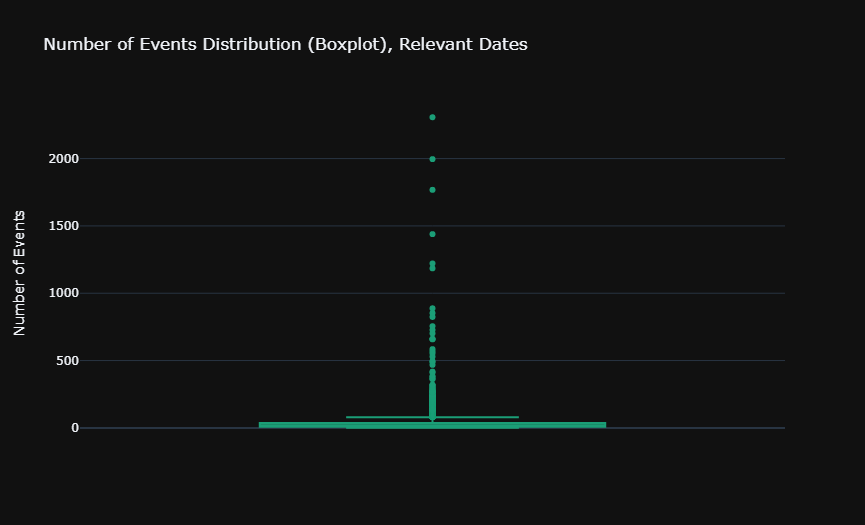

Zoomed-in:

![Plot%203.2%20%28Number%20of%20Events%20Distribution%20(boxplot%29,%20Relevant%20Dates,%20zoomed).png](attachment:Plot%203.2%20%28Number%20of%20Events%20Distribution%20(boxplot%29,%20Relevant%20Dates,%20zoomed).png)
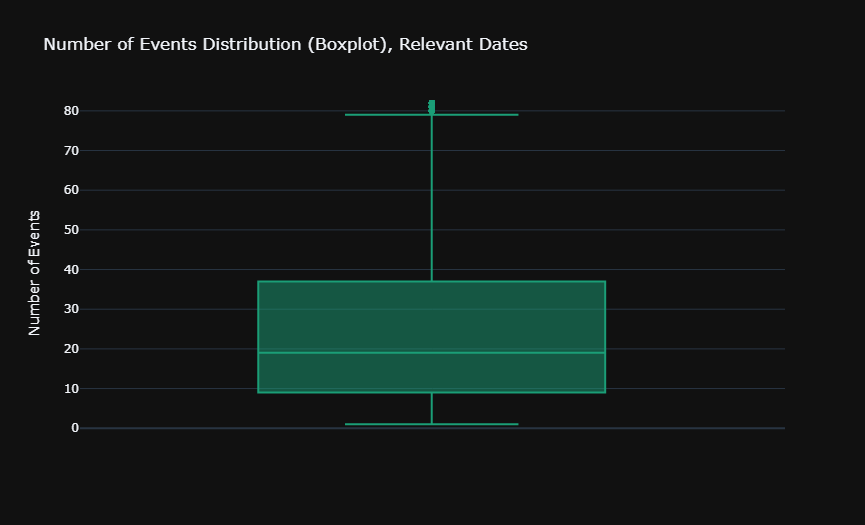

Hovering over the boxplot above makes it clear that all figures remain the same as in the previous boxplot:

Q1 (25th percentile) = 9 events.

Q2 (median) = 19 events (the only thing that changed).

Q3 (75th percentile) = 37 events.

Top whisker cap = 79 events.

Let's re-calculate the percentiles we calculated earlier:

In [35]:
print ('1st, 5th, 10th, 90th, 95th and 99th percentile values (in that order):')
np.percentile(relevant_user_events['number_of_events'], [1, 5, 10, 90, 95, 99])

1st, 5th, 10th, 90th, 95th and 99th percentile values (in that order):


array([  1.  ,   3.  ,   5.  ,  64.  ,  88.  , 200.89])

Only the 95th percentile value changed slightly - decreased by 1.

Though it's starting to look clear where this is going, let's complete our check:

In [36]:
# number of users above the top whisker cap (more than 79 events):
print ('Number of users with 80 events or more:', len(relevant_user_events.query('number_of_events > 79')))

# their share of entries:
print ('Percentage of events by users with more than 79 events each: {:.2%}'.format(
    relevant_user_events.query('number_of_events > 79')['number_of_events'].sum() / len(logs)))

# number of users above the 95th percentile:
print ('Number of users above the 95th percentile:', len(
    relevant_user_events[relevant_user_events['number_of_events'] >
                         (np.percentile(relevant_user_events['number_of_events'], 95))]))

# their share of entries:
print ('Percentage of events by users above the 95th percentile: {:.2%}'.format(
    relevant_user_events[relevant_user_events['number_of_events'] > 
                         (np.percentile(relevant_user_events['number_of_events'], 95))]\
    ['number_of_events'].sum() / len(logs)))

Number of users with 80 events or more: 489
Percentage of events by users with more than 79 events each: 33.37%
Number of users above the 95th percentile: 375
Percentage of events by users above the 95th percentile: 29.41%


These are very similar numbers as we had before - 494, 33.35%, 372, 29.12%, respectively.

As was stated, we are NOT going to remove the outliers just YET. We are going to study the clean data including all the users, and later on we will repeat our calculations/tests with the filtered data, without the outliers.

In [37]:
# checking the amount of users in each group (this shouldn't change much, as only 13 were removed)
print ('Number of members in group 246:', logs.query('group_id == 246')['user_id'].nunique())
print ('Number of members in group 247:', logs.query('group_id == 247')['user_id'].nunique())
print ('Number of members in group 248:', logs.query('group_id == 248')['user_id'].nunique())

Number of members in group 246: 2484
Number of members in group 247: 2517
Number of members in group 248: 2537


We have more or less the same amount of users in all the groups. We already know from before that all users are assigned to one group only.

# Studying the Event Funnel
Time to study the user's behaviour itself.

The first thing we will check is the **frequency of occurence** of the 5 types of events. We already know that, for example, the `tutorial` event isn't something most users are going through, simply because they do not need it, for whatever reason. Thus, we expect its frequency to be low. On the other hand, the `MainScreenAppear` event is likely to be the most frequent, as it is "the door" of the app, and usually one must pass through it before one can do anything else.

We will sort the events by decreasing frequency.

In [38]:
# reminder of how our data looks like
logs.head()

,event_name,user_id,event_timestamp,group_id,event_date
0,MainScreenAppear,7701922487875823903,2019-08-01 00:00:57,247,2019-08-01
1,MainScreenAppear,2539077412200498909,2019-08-01 00:01:45,247,2019-08-01
2,OffersScreenAppear,3286987355161301427,2019-08-01 00:02:21,248,2019-08-01
3,OffersScreenAppear,3187166762535343300,2019-08-01 00:02:23,247,2019-08-01
4,MainScreenAppear,1118952406011435924,2019-08-01 00:03:25,248,2019-08-01


In [39]:
event_frequency = logs.groupby('event_name').agg(
    event_occurences = ('event_timestamp', 'count')
).sort_values(by = 'event_occurences', ascending = False).reset_index()

event_frequency

,event_name,event_occurences
0,MainScreenAppear,117850
1,OffersScreenAppear,46509
2,CartScreenAppear,42338
3,PaymentScreenSuccessful,33949
4,Tutorial,1010


In [40]:
# setting a few color schemes.

pio.templates["dark2"] = go.layout.Template(
    layout=go.Layout(
        colorway = px.colors.qualitative.Dark2
    )
)

pio.templates.default = "plotly_dark+dark2" 

In [ ]:
# visualizing the funnel
# NOTE: we have to do it using the `go` method like below, and NOT the simple `px.funnel` method, 
# in order to be able to add percentages to every step!

fig = go.Figure(go.Funnel(
    y = event_frequency['event_name'],
    x = event_frequency['event_occurences'],
    textinfo = 'value + percent initial'
))

fig.update_layout(title = 'General Event Funnel (Number of Occurences)', font=dict(size=16))
fig.update_yaxes(title = 'Name of Event')

fig.show()

![Plot%204%20%28General%20Event%20Funnel%20(Number%20of%20Occurences%29).png](attachment:Plot%204%20%28General%20Event%20Funnel%20(Number%20of%20Occurences%29).png)
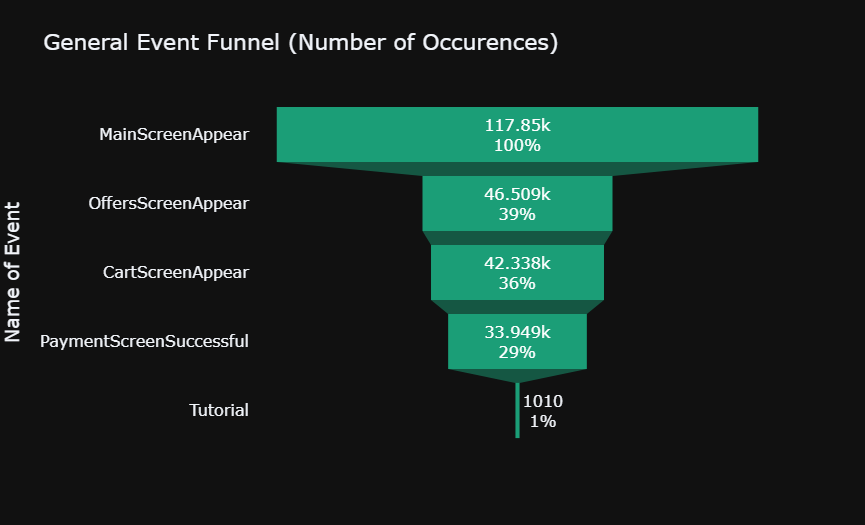

Right off the bat, we can see that most occurences do belong to the `MainScreenAppear`, as one might expect. Also, we can see that the "steps" down the funnel follow a logical order - main screen comes first (a user enters the app), then the offers screen (a user looks at possible items and their costs), then the cart screen (a user added an item or items, and now reviews their cart before paying), and finally the payment success screen (the user has paid and completed the order). It makes sense that the number of occurences of each event will be higher than that of the next one. Again, we are ignoring the tutorial step, as it is not mandatory to complete in order to make a purchase.

Let's see how things look if we make a distinction between the three groups:

In [ ]:
# making the relevant table
event_frequency_groups = logs.groupby(['event_name', 'group_id']).agg(
    event_occurences = ('event_timestamp', 'count')
).sort_values(by = 'event_occurences', ascending = False).reset_index()

# plotting the funnel
fig = go.Figure(go.Funnel(
    name = 'Group 246',
    y = event_frequency_groups[event_frequency_groups['group_id']==246]['event_name'],
    x = event_frequency_groups[event_frequency_groups['group_id']==246]['event_occurences'],
    textinfo = "value + percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group 247',
    y = event_frequency_groups[event_frequency_groups['group_id']==247]['event_name'],
    x = event_frequency_groups[event_frequency_groups['group_id']==247]['event_occurences'],
    textinfo = "value + percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group 248',
    y = event_frequency_groups[event_frequency_groups['group_id']==248]['event_name'],
    x = event_frequency_groups[event_frequency_groups['group_id']==248]['event_occurences'],
    textinfo = "value + percent initial"))

fig.update_layout(title = 'Event Funnel by Groups (Number of Occurences)')
fig.update_yaxes(title = 'Name of Event')

fig.show()

![Plot%205%20%28Event%20Funnel%20by%20Groups%20(Number%20of%20Occurences%29).png](attachment:Plot%205%20%28Event%20Funnel%20by%20Groups%20(Number%20of%20Occurences%29).png)
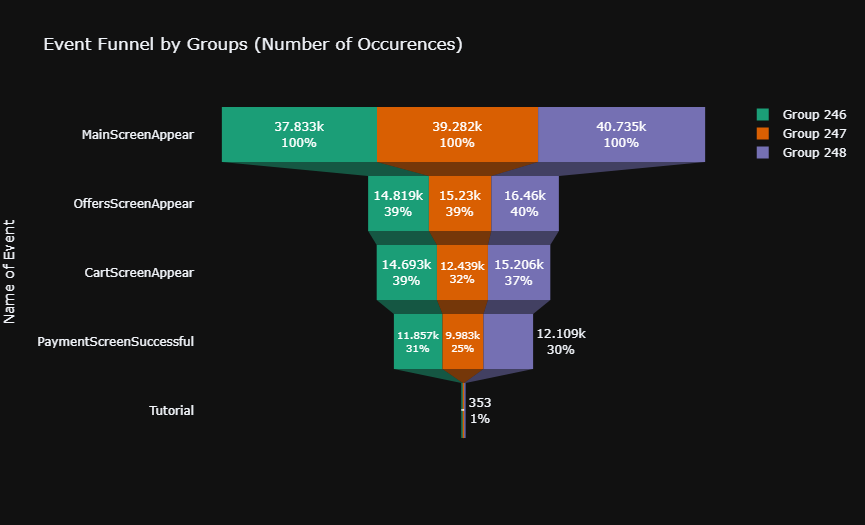

We have plotted the above funnels just to see how the numbers differ from one another (especially how group 248, the test group, performs in comparison to the control groups). We will NOT make any conclusions yet, since we will need to apply some statistical tools (tests) in order to see what these numbers mean. That will come later.

Next, we will check for the *amount of users* who performed each of these actions at least once. These will give us a better clue about retention/churn rates.

We will create a new table for that, named `event_users`. DO NOT CONFUSE IT with the earlier `user_events` table, which showed something else - it showed how many users performed 1 type of action, any 2 types of action, and so on. The following table shows, for any type of action, how many unique users have completed it.

In [43]:
event_users = logs.groupby('event_name').agg(
    number_of_users = ('user_id', 'nunique')
).sort_values(by = 'number_of_users', ascending = False).reset_index()

# adding another column, showing the percentage of the number of users who performed each action, 
# from the *total* amount of users.
event_users['percentage_from_total'] = ( 100 * (event_users['number_of_users'] / 
                                                logs['user_id'].nunique())).round(decimals = 2)

event_users

,event_name,number_of_users,percentage_from_total
0,MainScreenAppear,7423,98.47
1,OffersScreenAppear,4596,60.97
2,CartScreenAppear,3736,49.56
3,PaymentScreenSuccessful,3540,46.96
4,Tutorial,843,11.18


In [ ]:
# visualizing the funnel(s)
# number of users funnel
fig = go.Figure(go.Funnel(
    y = event_users['event_name'],
    x = event_users['number_of_users'],
    textinfo = 'value + percent initial + percent previous'
))

fig.update_layout(title = 'General Event Funnel (Number of Users per Action)', font=dict(size=16))
fig.update_yaxes(title = 'Name of Event')

fig.show()

# percentage of users funnel
fig = go.Figure(go.Funnel(
    y = event_users['event_name'],
    x = event_users['percentage_from_total'],
))

fig.update_layout(title = 'General Event Funnel (% of Users From Total)', font=dict(size=16))
fig.update_yaxes(title = 'Name of Event')

fig.show()

![Plot%206%20%28General%20Event%20Funnel%20(Number%20of%20Users%20Per%20Action%29).png](attachment:Plot%206%20%28General%20Event%20Funnel%20(Number%20of%20Users%20Per%20Action%29).png)
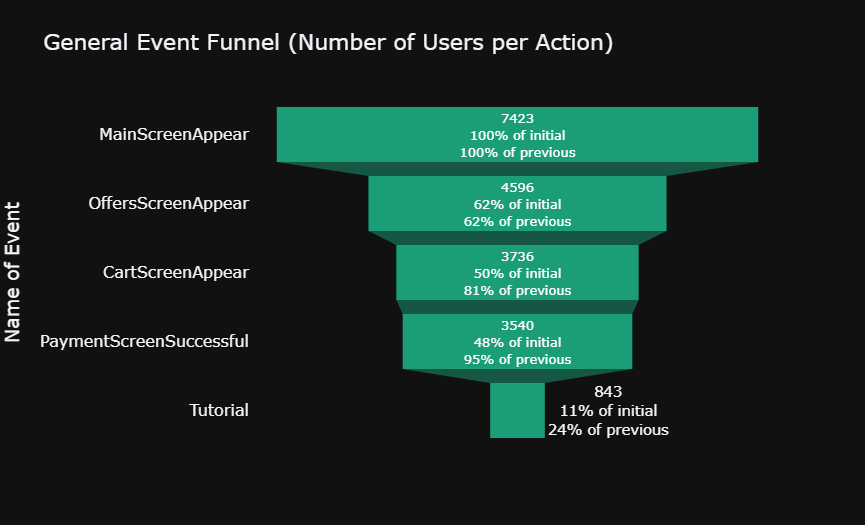

![Plot%207%20%28General%20Event%20Funnel%20(%25%20of%20Users%20from%20Total%29).png](attachment:Plot%207%20%28General%20Event%20Funnel%20(%25%20of%20Users%20from%20Total%29).png)
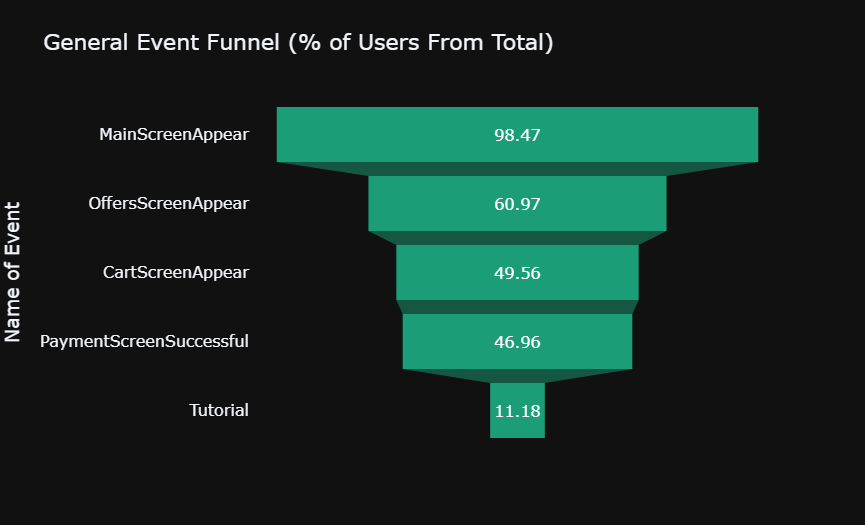

Before we will address the funnels above and make some interim conclusions, let's have a look at those same funnels, distinguished by groups:

In [45]:
event_users_groups = logs.groupby(['event_name', 'group_id']).agg(
    number_of_users = ('user_id', 'nunique')
).sort_values(by = ['group_id', 'number_of_users'], ascending = [True, False]).reset_index()

# adding another column, showing the percentage of the number of users who performed each action, 
# from the *total* amount of users in each group.
# we'll have to define a dictionary for each group's total number of users, first.
group_dict = {246: logs.query('group_id == 246')['user_id'].nunique(),
              247: logs.query('group_id == 247')['user_id'].nunique(),
              248: logs.query('group_id == 248')['user_id'].nunique()}

event_users_groups['percentage_from_group'] = (
    100 * (event_users_groups['number_of_users'] /
           event_users_groups['group_id'].map(group_dict))).round(decimals = 2)

event_users_groups

,event_name,group_id,number_of_users,percentage_from_group
0,MainScreenAppear,246,2450,98.63
1,OffersScreenAppear,246,1542,62.08
2,CartScreenAppear,246,1266,50.97
3,PaymentScreenSuccessful,246,1200,48.31
4,Tutorial,246,278,11.19
5,MainScreenAppear,247,2479,98.49
6,OffersScreenAppear,247,1523,60.51
7,CartScreenAppear,247,1239,49.23
8,PaymentScreenSuccessful,247,1158,46.01
9,Tutorial,247,284,11.28


In [ ]:
# plotting the funnels
# number of users per action funnel
fig = go.Figure(go.Funnel(
    name = 'Group 246',
    y = event_users_groups[event_users_groups['group_id']==246]['event_name'],
    x = event_users_groups[event_users_groups['group_id']==246]['number_of_users'],
    textinfo = 'value + percent initial + percent previous'))

fig.add_trace(go.Funnel(
    name = 'Group 247',
    y = event_users_groups[event_users_groups['group_id']==247]['event_name'],
    x = event_users_groups[event_users_groups['group_id']==247]['number_of_users'],
    textinfo = 'value + percent initial + percent previous'))

fig.add_trace(go.Funnel(
    name = 'Group 248',
    y = event_users_groups[event_users_groups['group_id']==248]['event_name'],
    x = event_users_groups[event_users_groups['group_id']==248]['number_of_users'],
    textinfo = 'value + percent initial + percent previous'))

fig.update_layout(title = 'Group Event Funnel (Number of Users per Action)')
fig.update_yaxes(title = 'Name of Event')

fig.show()

# percentage of group users funnel
fig = go.Figure(go.Funnel(
    name = 'Group 246',
    y = event_users_groups[event_users_groups['group_id']==246]['event_name'],
    x = event_users_groups[event_users_groups['group_id']==246]['percentage_from_group'],
))

fig.add_trace(go.Funnel(
    name = 'Group 247',
    y = event_users_groups[event_users_groups['group_id']==247]['event_name'],
    x = event_users_groups[event_users_groups['group_id']==247]['percentage_from_group'],
))

fig.add_trace(go.Funnel(
    name = 'Group 248',
    y = event_users_groups[event_users_groups['group_id']==248]['event_name'],
    x = event_users_groups[event_users_groups['group_id']==248]['percentage_from_group'],
))

fig.update_layout(title = 'Group Event Funnel (% of Users From Group)')
fig.update_yaxes(title = 'Name of Event')

fig.show()

![Plot%208%20%28Group%20Event%20Funnel%20(Number%20of%20Users%20per%20Action%29).png](attachment:Plot%208%20%28Group%20Event%20Funnel%20(Number%20of%20Users%20per%20Action%29).png)
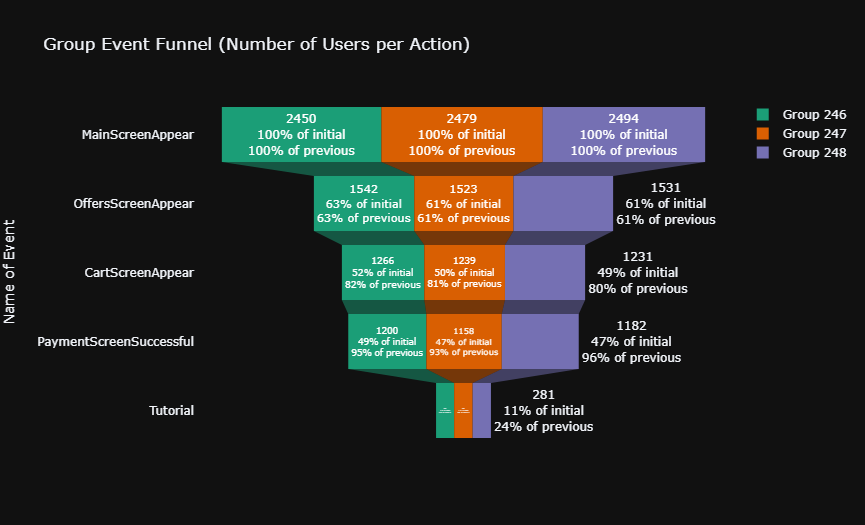

![Plot%209%20%28Group%20Event%20Funnel%20(%25%20of%20Users%20From%20Group%29).png](attachment:Plot%209%20%28Group%20Event%20Funnel%20(%25%20of%20Users%20From%20Group%29).png)
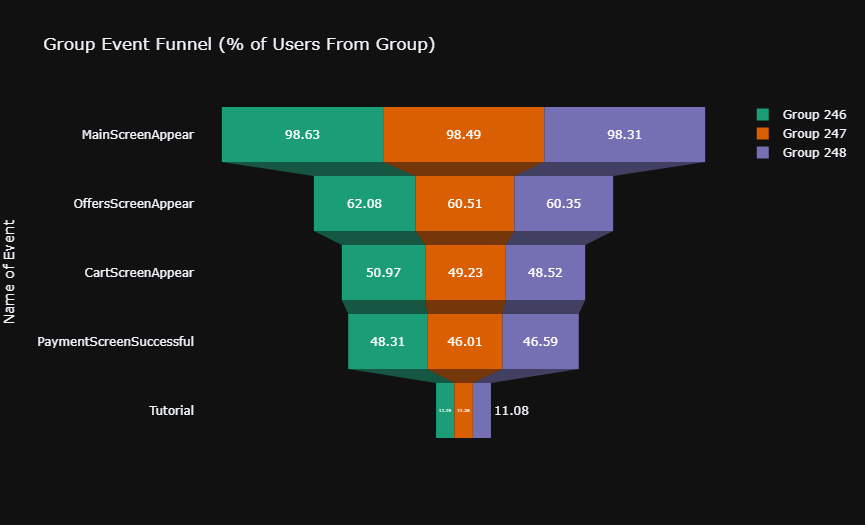

## Interim Conclusions
Looking at all the above funnels, we gather a few insights. Looking at the GENERAL funnels (all groups together):

1) **The step in which we lost most users is the transition between the main screen and the offers page.** This suggest there might be some problem in the main screen that discourages many users to go on and view an offers page. It might be, for example, a UI/UX issue or a technical issue (which makes the page to reload too many times, thus skews the data). These are just thoughts, nothing else.

2) Setting aside the main screen, **more than 3 in every 4 users** who made it to an offers screen, also made a purchase in the end. Meaning, a given user viewing an offers page is VERY likely to also make a purchase.

3) **Almost all users** who have viewed their carts (95%) also completed the order (didn't cancel or otherwise did not place an order). Meaning, there probably isn't any problem with the cart page, if so many users who see it also pay.

Looking at the GROUP funnels:

While these look lovely, they are only for first impression of how the groups differ from one another. More precise testing will be taking place later, and that's when the conclusions will come. Still, **just by looking at the numbers** - a very "naive" point of view - it looks like there is not much difference between the groups. However, looks can be deceiving. We'll see what the statistical tests show later on.

HOWEVER, we also have an **important reservation**:

The above numbers are true and very nice, IF we assume that all of the above events occur in **one, rigid sequence**. Meaning, that every user who made it to an offers page, *necessarily* got there from the main screen, anyone who made it to the cart page, *necessarily* got there from the offers screen, and so on. In other words, the above funnels and conclusions are under the assumption that users **did not / could not skip any steps** (except the tutorial), or simply navigate to any screen they'd like, in what order they wanted. While the sequence presented in the funnels above seems to be to most straightforward (except for the tutorial), the funnels don't take into account the de-facto sequence every user made, only the number of users who performed those actions.

To prove the last point, earlier we have seen that we have a small number of users who performed only type of action - and that action was NOT necessarily the tutorial or the main screen as we might expect - some of them only saw the offers page, *without* first seeing the main screen. How is that possible isn't relevant right now. It only demonstrates that some users may have gone through a different sequence of events.

This means that we might have users who have seen the main page, then jumped directly to their cart page somehow, and then paid (didn't go through the offers page - maybe they already had an item in their cart from an earlier session, and now they just returned to complete the order?). Others might have not even seen the main screen, but got straight into the offers page (via promotional link sent to them by email, or a friend?), and then moved to the subsequent steps.

This doesn't necessarily mean our conclusions above about retention rates are wrong, it just means that the numbers may not be 100% accurate.

The above funnels, both general and group-separated, also calculate and show us a very valuable information. Note: the points below are correct under the assumption described just a moment ago!

1) They show us **what share of users make the entire journey from the first event to payment** (regardless of precise event sequence!). If we look at the `General Event Funnel (Number of Users Per Action)` funnel, we can see that 48% of users have made the entire journey. For the individual groups, the numbers are 49% for group 246, 47% for group 247, and the same for group 248. 

2) They show us **the share of users that proceed from one stage to the next**. For example, in the General Event Funnel, we see that 62% made it to the offers page from the main screen, 81% made it to the cart page from the offers page, and 95% made it to payment successful page from the cart page.
The numbers for the individual groups can be seen in the `Group Event Funnel (Number of Users Per Action)`, marked `% of previous` in each block.

The other two funnels, showing only the percentage of users in each step **from the total amount of users in each group / all users in the data**, show slightly different numbers only because not all users (but roughly 98%) have seen the main screen (we don't know why and how it happened). The figures in these funnels are a bit more precise, since they take **all** users in the groups into account, whether they went through the main screen or not, while the former funnels (from points 1 and 2 above) consider the number of users who have seen the main screen as the starting point, regardless of how many users were in the group. If all users in each group would visit the main screen - the numnbers in both types of funnels would coincide (and then we wouldn't have plotted the "only-percentage" funnels, since that'd be redundant).

## Checking User Sequences
What we will do next is prove our statement above that some users can go through all 4 stages (excluding the tutorial), but in different sequences. As mentioned above, the funnels in the previous section didn't take into account the exact sequence each user has been through.

In [47]:
# first, we'll take the `logs` dataframe, and sort it by `user_id` and then by `event_timestamp`, 
# to get them all in chronological order. also, we will exclude the `tutorial` event.
sorted_logs = logs[logs['event_name'] != 'Tutorial'].sort_values(by = ['user_id', 'event_timestamp'])
sorted_logs.head()

,event_name,user_id,event_timestamp,group_id,event_date
194925,MainScreenAppear,6888746892508752,2019-08-06 17:06:34,246,2019-08-06
206843,MainScreenAppear,6909561520679493,2019-08-06 21:52:54,247,2019-08-06
206846,PaymentScreenSuccessful,6909561520679493,2019-08-06 21:52:58,247,2019-08-06
206847,CartScreenAppear,6909561520679493,2019-08-06 21:52:58,247,2019-08-06
206848,MainScreenAppear,6909561520679493,2019-08-06 21:52:58,247,2019-08-06


As a side note - the above table demonstrates precisely a probelm we have discussed before. If we look at the bottom 3 rows, we see the same user performing three different actions at supposedly the same second. These might be those very same implicit duplicates we talked about. The problem is that if we removed them, that user would have shown to have paid for something on August 6th, 2019, at 21:52, but we wouldn't get the data about the other events. We have no way of knowing which one of those really did appear first, and why did they all register at the exact same second. Not to mention that could also affect the result of the function below, as some events would be deleted and the order of appearance might change as a result.

Next, we will create a function that iterates over all user id's, and registers all events they went through, in chronological order. It will then elimiate all duplicates, leaving each event type only once, in the order they were performed, even if it wasn't during the same session.


In [48]:
def sequence_order (user_id: int) -> list:
    """
    The functions takes a user ID, 
    and returns a list of all 4 events in the order in which they first appeared.
    """
    
    user_sequence = sorted_logs[sorted_logs['user_id']==user_id]
    
    return user_sequence['event_name'].drop_duplicates().to_list()

In [49]:
# testing the function. 
# we will use the second id we in the table above (and we can already see the order we're supposed to get)
sequence_order (6909561520679493)

['MainScreenAppear',
 'PaymentScreenSuccessful',
 'CartScreenAppear',
 'OffersScreenAppear']

We already see the function works, and we also see this particular user had a sequence which doesn't make too much sense - main screen first (which is ok), payment screen last (which is very weird), then cart (what?!) and then offers screen. Doesn't make too much sense. Of course part of the blame lies withing the fact that we have quite a few entries sharing the user id and the timestamp, but not the event name (see previous markdown cell). 

That is to say - the above function is far from perfect, and we must not claim the returned results are exact in any way. This was done just to show that we can't take for granted that all users went through all the events in one specific order.

BY THE WAY, let's see what sequence the same user_id would get, had we removed the alleged implicit duplicates:

In [50]:
test = logs.drop_duplicates(subset = ['user_id', 'event_timestamp']).reset_index(drop = True)

sorted_logs = test[test['event_name'] != 'Tutorial'].sort_values(by = ['user_id', 'event_timestamp'])

test[test['user_id']==6909561520679493]

,event_name,user_id,event_timestamp,group_id,event_date
187318,MainScreenAppear,6909561520679493,2019-08-06 21:52:54,247,2019-08-06
187320,PaymentScreenSuccessful,6909561520679493,2019-08-06 21:52:58,247,2019-08-06
187328,OffersScreenAppear,6909561520679493,2019-08-06 21:53:04,247,2019-08-06


Wouldn't you know it? the cart stage magically disappeared. The remaining events show up in the same order as they did before, which is no surprise. the cart stage was removed just because it never appeard in a unique timestamp for that user, or at least did not appear FIRST in a sequence of events which shared a specific timestamp.

What else does it tell us? it tells us that had we removed the implicit duplicates, **it would have affected our funnels as well**. That is because it might have caused some users to "lost" some of their events, for the same reason the user above lost his cart stage.

The effect might not have been too drastic, but nevertheless there would be an effect.

Below we will show all the sequence combinations our function can come up with, and how many users followed each. This will demonstrate how imperfect (not to say *chaotic*) our data can be in regard to event registration, whatever the reason behind it may be.

In [51]:
user_sequences = []
for user_id in sorted_logs['user_id'].unique():
    user_sequences.append([user_id , sequence_order(user_id)])

sequences_data = pd.DataFrame(user_sequences, columns = ['user_id', 'sequence'])
sequences_data['sequence'].value_counts()

[MainScreenAppear]                                                                   2884
[MainScreenAppear, OffersScreenAppear]                                                884
[MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]     811
[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]     774
[MainScreenAppear, CartScreenAppear, OffersScreenAppear, PaymentScreenSuccessful]     444
[MainScreenAppear, PaymentScreenSuccessful, OffersScreenAppear, CartScreenAppear]     319
[MainScreenAppear, OffersScreenAppear, CartScreenAppear]                              229
[MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear]     224
[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful]                       136
[MainScreenAppear, CartScreenAppear, PaymentScreenSuccessful, OffersScreenAppear]     120
[MainScreenAppear, CartScreenAppear, OffersScreenAppear]                              116
[MainScree

Point proven. We can see that only 811 (out of more than 7,000!) users have - supposedly - went through the "logical" sequence of main screen, offers, cart, payment. At the very least, among all users who had all four event logs in the data, this sequence had the highest number of users, but we can see they are far from being the majority - as more than 2000 others have went through the four events in various other sequences. 

Now that we are done playing around, it's time to do what we came for:

Checking if changing the fonts of the app had any effect on users.

# Experiment Results
Let's get a reminder how many users we have in each group - INCLUDING the outliers:

In [52]:
print ('Number of members in group 246 (control group):', logs.query(
    'group_id == 246')['user_id'].nunique())
print ('Number of members in group 247 (control group):', logs.query(
    'group_id == 247')['user_id'].nunique())
print ('Number of members in group 248 (test group):', logs.query(
    'group_id == 248')['user_id'].nunique())

Number of members in group 246 (control group): 2484
Number of members in group 247 (control group): 2517
Number of members in group 248 (test group): 2537


More or less the same amount. We will re-check this later, when we filter the data and take out the outliers we determined earlier.
Also, we already know from before that all users belong to only one group. We won't re-check this now.

Groups 246 and 247 are our control groups. Our first task would be the compare them, and see that our test mechanism works properly. Our desired result in this part would be to find out that there are no statistically significant differences between these two groups, as they are supposed to be the same - the users of both were using the app using the current font set, so we shouldn't see any major difference.

This is the time to emphasize two things. 

1) All tests to be conducted below are tests of **proportions**, not tests of **averages**. Meaning, we will only be using the **Z-test** in our analysis, and not other tests like t-test or Mann-Whitney, as these are irrelevant to us.

2) In all the tests below, the same null hypothesis will be tested:
    
* **Null Hypothesis**: There is NO statistically significant difference between the proportions of the two groups being compared (they are the same).
    
* **Alternative Hypothesis**: There IS a statistically significant difference between the proportions of the two groups being compared (they are NOT the same).

We can use our old `event_users_groups` table below. The function will know which value to take from the `number_of_users`, according to group and event type.

In [53]:
event_users_groups

,event_name,group_id,number_of_users,percentage_from_group
0,MainScreenAppear,246,2450,98.63
1,OffersScreenAppear,246,1542,62.08
2,CartScreenAppear,246,1266,50.97
3,PaymentScreenSuccessful,246,1200,48.31
4,Tutorial,246,278,11.19
5,MainScreenAppear,247,2479,98.49
6,OffersScreenAppear,247,1523,60.51
7,CartScreenAppear,247,1239,49.23
8,PaymentScreenSuccessful,247,1158,46.01
9,Tutorial,247,284,11.28


In [54]:
users = {'group_id': [246, 247, 248], 'users': [logs.query('group_id == 246')['user_id'].nunique(), 
                                                logs.query('group_id == 247')['user_id'].nunique(), 
                                                logs.query('group_id == 248')['user_id'].nunique()]}
users_table = pd.DataFrame(data=users)
users_table

,group_id,users
0,246,2484
1,247,2517
2,248,2537


What we are going to do is compare the proportion of users in groups 246 and 247 which performed the each type of action. Let's take as an example the most prevalent action - seeing the main screen. We can already see the shares above:

Group 246: 98.63% of users in this group saw the main screen.

Group 247: 98.49% of users in this group saw the main screen.

That looks like a negligible difference, but is it really so? That's what the Z-test is for.

We will create function that takes the equivalent proportions of two groups, of the same event, and compares them. We will test the null hypothesis that the two proportions are the same - meaning, there is no statistical difference between them. Our alpha value will be the standard 0.05, and right now we hope to *fail* to reject the null hypothesis. Meaningm we hope our p-value will be greater than our alpha.

In our function, we incorporate a library function called `proportions_ztest`, imported from `statmodels.stats.proportion`, rather than write all the math ourselves. According to the resultant p-value of the `proportions_ztest`, the function will print whether we reject the null hypothesis or failed to do so.

In [55]:
def check_zvalue (group1: int, group2: int, event: str, alpha_value: float):
    """Description of the function:
    
    Parameters:
    group1(int): ID number of the first group to be compared.
    group2(int): ID number of the second group to be compared.
    event(string): Type of event, of which the group proportions are compared.
    alpha_value(float): the alpha value setting for the test.
    
    Variables:
    trials1 / trials2 : the total amount of users in the respective group.
    successes1 / successes2: the amount of users in the respective group who performed the event in 
    question.
    
    Output:
    The function prints the following:
    1) Groups being compared.
    2) Event being compared.
    3) Total number of users in each group
    4) Number of users within the group who used the event.
    5) The proportion of the latter in the group.
    6) Results of the Z-test: p-value, and whether the null hypothesis has been rejected or failed to 
       reject.
    
    """
    
    print ('Compared groups:', group1, 'and', group2, '.', 'Event in question:', event)
    print ()
    
    trials1 = int(users_table[users_table['group_id']==group1]['users'])
    trials2 = int(users_table[users_table['group_id']==group2]['users'])
    
    successes1 = int(event_users_groups[(event_users_groups['group_id'] == group1) & 
                                        (event_users_groups['event_name'] == event)]['number_of_users'])
    successes2 = int(event_users_groups[(event_users_groups['group_id'] == group2) &
                                        (event_users_groups['event_name'] == event)]['number_of_users'])
    
    print ('Total users in group', group1, "-", trials1)
    print ('total of users who performed the event -', successes1)
    print ('Proportion in the group: {:.2%}'.format(successes1/trials1))
    print ()
    print ('Total users in group', group2, "-", trials2)
    print ('total of users who performed the event -', successes2)
    print ('Proportion in the group: {:.2%}'.format(successes2/trials2))
    print ()
    
    alpha = alpha_value
    stat, p_value = proportions_ztest([successes1, successes2], [trials1 ,trials2])
    
    print ('Z-test results:')
    print ('p-value: {:.5f}'.format(p_value))
    print ('alpha value:', alpha)
    if p_value < alpha:
        print ('Null hypothesis rejected - the proportions are significantly different')
    else:
        print ('Failed to reject null hypothesis - there is no reason to consider the proportions different')
    
    print ('-------------------------------------------------------------------------------------------')

Some explanations:

`group1` and `group2` - the groups to be compared.

`event` - self explanatory, this is the event type we check.

`trials1` and `trials2` are universal terms, which in our context mean `the total amount of users in a specific group`.

`successes1` and `successes2` are also universal terms, which in our context mean `the amount of users in the group who performed the action (event) in question`.

In [56]:
# creating the list of events, and removing `tutorial` as we don't need it.
event_list = list(event_users_groups['event_name'].unique())
event_list.remove('Tutorial')
event_list

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

All that we have left to do now is simply create a simple loop to iterate over all event types - except `tutorial`, and perform the z-test for each one.
Right now we are only focused on the two control groups, so we expect that in all cases the p-value will be greater than alpha.

The alpha value in all tests below is set to 0.05, the industry standard.

In [57]:
for event in event_list:
    check_zvalue(246, 247, event, 0.05)

Compared groups: 246 and 247 . Event in question: MainScreenAppear

Total users in group 246 - 2484
total of users who performed the event - 2450
Proportion in the group: 98.63%

Total users in group 247 - 2517
total of users who performed the event - 2479
Proportion in the group: 98.49%

Z-test results:
p-value: 0.67562
alpha value: 0.05
Failed to reject null hypothesis - there is no reason to consider the proportions different
-------------------------------------------------------------------------------------------
Compared groups: 246 and 247 . Event in question: OffersScreenAppear

Total users in group 246 - 2484
total of users who performed the event - 1542
Proportion in the group: 62.08%

Total users in group 247 - 2517
total of users who performed the event - 1523
Proportion in the group: 60.51%

Z-test results:
p-value: 0.25480
alpha value: 0.05
Failed to reject null hypothesis - there is no reason to consider the proportions different
----------------------------------------

Perfect. All p-values are greater than alpha. This means that **for all event types, groups 246 and 247 are the same** in terms of the proportion of the amount of users who performed each action to the total amount of users in the group.

Next - we will compare groups 246 and the test group 248, and see what we come up with:

In [58]:
for event in event_list:
    check_zvalue(246, 248, event, 0.05)

Compared groups: 246 and 248 . Event in question: MainScreenAppear

Total users in group 246 - 2484
total of users who performed the event - 2450
Proportion in the group: 98.63%

Total users in group 248 - 2537
total of users who performed the event - 2494
Proportion in the group: 98.31%

Z-test results:
p-value: 0.34706
alpha value: 0.05
Failed to reject null hypothesis - there is no reason to consider the proportions different
-------------------------------------------------------------------------------------------
Compared groups: 246 and 248 . Event in question: OffersScreenAppear

Total users in group 246 - 2484
total of users who performed the event - 1542
Proportion in the group: 62.08%

Total users in group 248 - 2537
total of users who performed the event - 1531
Proportion in the group: 60.35%

Z-test results:
p-value: 0.20836
alpha value: 0.05
Failed to reject null hypothesis - there is no reason to consider the proportions different
----------------------------------------

Interestingly, we have failed to reject all null hypotheses here as well. This means that **control group 246 and the test group 248 are the same** as far as user behaviour (or in other words, conversion) goes. There are no statistically significant differences between the proportions which were compared.

Let's see if the other control group (247) gives us anything different:

In [59]:
for event in event_list:
    check_zvalue(247, 248, event, 0.05)

Compared groups: 247 and 248 . Event in question: MainScreenAppear

Total users in group 247 - 2517
total of users who performed the event - 2479
Proportion in the group: 98.49%

Total users in group 248 - 2537
total of users who performed the event - 2494
Proportion in the group: 98.31%

Z-test results:
p-value: 0.60017
alpha value: 0.05
Failed to reject null hypothesis - there is no reason to consider the proportions different
-------------------------------------------------------------------------------------------
Compared groups: 247 and 248 . Event in question: OffersScreenAppear

Total users in group 247 - 2517
total of users who performed the event - 1523
Proportion in the group: 60.51%

Total users in group 248 - 2537
total of users who performed the event - 1531
Proportion in the group: 60.35%

Z-test results:
p-value: 0.90645
alpha value: 0.05
Failed to reject null hypothesis - there is no reason to consider the proportions different
----------------------------------------

All null hypotheses failed to reject. AGAIN. Meaning - **control group 247 and the test group 248 are the same** as far as user behaviour (conversion) goes. There are no statistically significant differences between the proportions which were compared.

One last thing we will do is to **combine** the two test groups - 246 and 247, and compare them as a single group to the test group, 248.
Since we already established that groups 246 and 247 are statistically the same, the combined proportions for each event should be same as in the individual groups. And, since we also established that neither group is statistically different than the test group, 248, we expect that here, too, all null hypotheses will fail to be rejected.

We'll have to make a few preparations before we can execute the test, since we need to create a new "group" which is the combination of 246 and 247. We can also just fill-in the values manually, but this is not a good practice.

In [60]:
# first, we will update the `users_table` with our new "group"'s number of users
# we'll name it 249 (just an arbitrary number)
group249_users = (int(users_table.query('group_id == 246')['users']) + 
                  int(users_table.query('group_id == 247')['users']))
group249_row = pd.DataFrame(data = {'group_id': [249], 'users': [group249_users]})

users_table = pd.concat([users_table, group249_row]).reset_index(drop = True)

In [61]:
users_table

,group_id,users
0,246,2484
1,247,2517
2,248,2537
3,249,5001


In [62]:
# now, we will update the `event_users_groups` by adding group 249, 
# and combining the numbers from 246 and 247.

# slice the groups to be combined from `event_users_groups`
group246 = event_users_groups.query('group_id == 246')
group247 = event_users_groups.query('group_id == 247')

# make a copy of the dataframe (because it has the structure we need), 
# we'll edit the columns in a bit
group249 = group246.copy()

# edit the group id, change it to 249
group249['group_id'] = 249

# sum the corresponding values in the `number_of_users` column of groups 246 and 247, 
# and put the results in that column for group 249
group249['number_of_users'] = group246['number_of_users'].add(group247['number_of_users'], 
                                                              fill_value=group247['number_of_users'])

# changing datatype, the above line results in float.
group249['number_of_users'] = group249['number_of_users'].astype('int64')

# fixing the `percentage_from_group` column values accordingly.
group249['percentage_from_group'] =(100 * group249['number_of_users'] / 
                                    int(users_table.query('group_id == 249')['users'])).round(decimals = 2)

# checking the result
group249

,event_name,group_id,number_of_users,percentage_from_group
0,MainScreenAppear,249,4929,98.56
1,OffersScreenAppear,249,3065,61.29
2,CartScreenAppear,249,2505,50.09
3,PaymentScreenSuccessful,249,2358,47.15
4,Tutorial,249,562,11.24


In [63]:
# adding the above table to the `event_users_groups`
event_users_groups = pd.concat([event_users_groups, group249])

In [64]:
# cleaning up a little
event_users_groups = event_users_groups.sort_values(by = ['group_id', 'number_of_users'], 
                                                    ascending = [True, False]).reset_index(drop = True)

# checking the result
event_users_groups

,event_name,group_id,number_of_users,percentage_from_group
0,MainScreenAppear,246,2450,98.63
1,OffersScreenAppear,246,1542,62.08
2,CartScreenAppear,246,1266,50.97
3,PaymentScreenSuccessful,246,1200,48.31
4,Tutorial,246,278,11.19
5,MainScreenAppear,247,2479,98.49
6,OffersScreenAppear,247,1523,60.51
7,CartScreenAppear,247,1239,49.23
8,PaymentScreenSuccessful,247,1158,46.01
9,Tutorial,247,284,11.28


Perfect. Now for the testing:

In [65]:
for event in event_list:
    check_zvalue(249, 248, event, 0.05)

Compared groups: 249 and 248 . Event in question: MainScreenAppear

Total users in group 249 - 5001
total of users who performed the event - 4929
Proportion in the group: 98.56%

Total users in group 248 - 2537
total of users who performed the event - 2494
Proportion in the group: 98.31%

Z-test results:
p-value: 0.39299
alpha value: 0.05
Failed to reject null hypothesis - there is no reason to consider the proportions different
-------------------------------------------------------------------------------------------
Compared groups: 249 and 248 . Event in question: OffersScreenAppear

Total users in group 249 - 5001
total of users who performed the event - 3065
Proportion in the group: 61.29%

Total users in group 248 - 2537
total of users who performed the event - 1531
Proportion in the group: 60.35%

Z-test results:
p-value: 0.42877
alpha value: 0.05
Failed to reject null hypothesis - there is no reason to consider the proportions different
----------------------------------------

Surprise, surprise. All null hypotheses failed to reject. Just as expected.

## Interim Conclusions (2)
We have performed no less than 16 Z-tests, compared different combinations of the control groups and the test group, trying to figure out whether changing the font set in the app made any difference in user behaviour. As it turns out, according to our results - **there is simply no significant difference**: The slight differences in proportions of users who performed each action type in the purchase sequence are not statistically signifcant, between all three groups. This result is further validated by the fact we have conducted an A/A test (4 out of the 16 tests were actually a comparison of the two control groups), and since we have found no difference between the control groups, we could say our recruitment/testing methodology is valid. The fact that there is no difference between the control and test groups is not due to some error in the process, but a real result.

Now, there are two things we need to consider.

1) We have made 16 tests using the same overall population(s). The more test we perform with the same sample(s), the higher the risk of getting a "false-positive", or a "type-I error", meaning that we might reject a null hypothesis which in fact should NOT be rejected. In general, if we use an alpha value of 0.1 for an individual test, it would mean that statistically 1 out of 10 tests would yield a false result (like the type-I error). In that case, it is common practice to LOWER the alpha value according to the number of tests to be conducted, such as to lower the chance of such falst positives. If there are N tests to be conducted, then our alpha value should be, in this example, 0.1 / N. This is known as the **Bonferroni Correction**. In our case, N = 16, and our alpha was 0.05. This means that in order to lower the risk of false-postivies, our alpha value for tests should be 0.05 / 16, which is 0.003125. Extremely low.

**Seeing as all of our Z-tests returned p-values greater than 0.05 anyway** - lowering the alpha value to 0.003125 wouldn't change the results at all - we will still fail to reject all null hypotheses, since the definition of the alpha value does NOT influence the calculation of the p-value. It's just a value to which the latter is compared to. 

HOWEVER, we did note there was ONE test in which the p-value was greater than 0.05, but lower than 0.1 (groups 246 and 248, test for CartScreenAppear). Had we used alpha = 0.1, The null hypothesis of that test would be rejected. If we applied the Bonferroni Correction, and set the alpha value to 0.1 / 16, which is 0.00625 - we would fail the null hypothesis in question.

We will still re-run all of our tests using the lower alpha value, even though we know it is pointless and our conclusion above won't change.

2) The above tests consider the **full populations** of each groups. Earlier, we have looked for outliers in the data - users with super-high amount of event logs. We considered every user with 80 event logs (and more) to be an outlier. There aren't too many users with those numbers (roughly 6.5%), and the fact that they have that many actions probably does not affect the test results above by much, since the tests are based on data which only takes into account if a given user has performed each type of action at least ONCE, and not *how many times* they did it. In other words, A user with just 4 events in his logs, one of each type, IS EQUAL to a user with 2000 events, 500 of each type.

Nevertheless, To further validate our results, we will create a `logs_filtered` data without the outliers, run the relevant code again, re-test all groups, and see if our results change.

Hang on tight, this will take a while.

First things first, we will now re-run all of the above tests (including the outliers), with the corrected alpha value - 0.05/16:
The output is going to be a bit lengthy...

In [66]:
for event in event_list:
    check_zvalue(246, 247, event, 0.05/16)
for event in event_list:
    check_zvalue(246, 248, event, 0.05/16)
for event in event_list:
    check_zvalue(247, 248, event, 0.05/16)
for event in event_list:
    check_zvalue(249, 248, event, 0.05/16)

Compared groups: 246 and 247 . Event in question: MainScreenAppear

Total users in group 246 - 2484
total of users who performed the event - 2450
Proportion in the group: 98.63%

Total users in group 247 - 2517
total of users who performed the event - 2479
Proportion in the group: 98.49%

Z-test results:
p-value: 0.67562
alpha value: 0.003125
Failed to reject null hypothesis - there is no reason to consider the proportions different
-------------------------------------------------------------------------------------------
Compared groups: 246 and 247 . Event in question: OffersScreenAppear

Total users in group 246 - 2484
total of users who performed the event - 1542
Proportion in the group: 62.08%

Total users in group 247 - 2517
total of users who performed the event - 1523
Proportion in the group: 60.51%

Z-test results:
p-value: 0.25480
alpha value: 0.003125
Failed to reject null hypothesis - there is no reason to consider the proportions different
--------------------------------

If anyone is surprised by the above results, raise your hand.

# Studying the Filtered Data, and Re-running the Tests
Next, we are going to create the `logs_filtered` dataframe, which only takes out all users with more than 79 events (meaning, users above the top whisker cap in our earlier boxplots).

In [67]:
outlier_users = relevant_user_events.query('number_of_events > 79')['user_id'].to_list()

# the amount of users to be removed:
len(outlier_users)

489

In [68]:
# creating the new dataframe and removing the outliers
logs_filtered = logs[~logs['user_id'].isin(outlier_users)].reset_index(drop = True)

logs_filtered.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161007 entries, 0 to 161006
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       161007 non-null  object        
 1   user_id          161007 non-null  int64         
 2   event_timestamp  161007 non-null  datetime64[ns]
 3   group_id         161007 non-null  int64         
 4   event_date       161007 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 16.3 MB


In [69]:
# checking that no user has more than 79 events:
logs_filtered['user_id'].value_counts().max()

79

In [70]:
# checking how many users we have, compared to the initial 7538:
logs_filtered['user_id'].nunique()

7049

Now we will need to repeat some of our earlier code, using `logs_filtered` instead of `logs` until the point we have the relevant tables with the number of users in each group and the amount of users who performed each action. This includes all visualizations (funnels). The code will be applied in the same sequence as above, but we will NOT make any remarks in between each table/visualization as we did above, as the results probably won't differ by much.

In [71]:
event_frequency_filtered = logs_filtered.groupby('event_name').agg(
    event_occurences = ('event_timestamp', 'count')
).sort_values(by = 'event_occurences', ascending = False).reset_index()

event_frequency_filtered

,event_name,event_occurences
0,MainScreenAppear,94980
1,OffersScreenAppear,29688
2,CartScreenAppear,20172
3,PaymentScreenSuccessful,15254
4,Tutorial,913


In [ ]:
# visualizing the funnel

fig = go.Figure(go.Funnel(
    y = event_frequency_filtered['event_name'],
    x = event_frequency_filtered['event_occurences'],
    textinfo = 'value + percent initial'
))

fig.update_layout(title = 'General Event Funnel (Number of Occurences), Filtered Data', font=dict(size=16))
fig.update_yaxes(title = 'Name of Event')

fig.show()

![Plot%2010%20%28General%20Event%20Funnel%20(Number%20of%20Occurences%29,%20Filtered%20Data).png](attachment:Plot%2010%20%28General%20Event%20Funnel%20(Number%20of%20Occurences%29,%20Filtered%20Data).png)
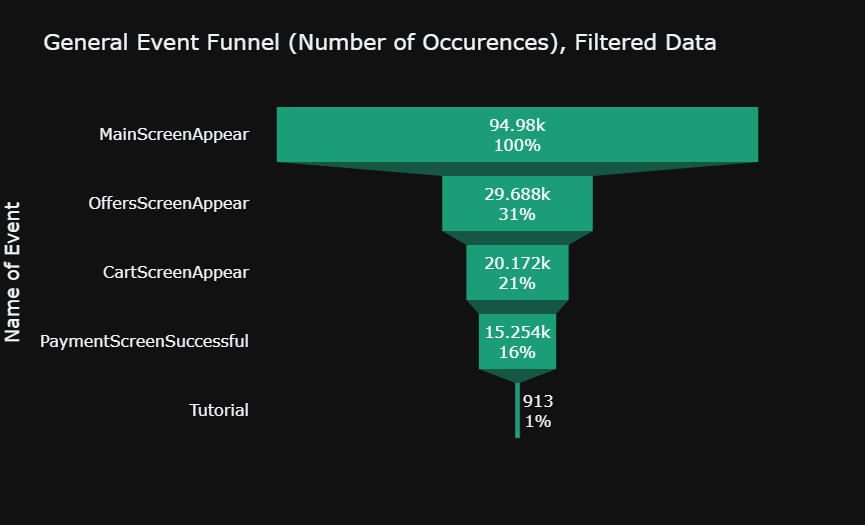

In [ ]:
# re-making the relevant group table
event_frequency_groups_filtered = logs_filtered.groupby(['event_name', 'group_id']).agg(
    event_occurences = ('event_timestamp', 'count')
).sort_values(by = 'event_occurences', ascending = False).reset_index()

# plotting the funnel
fig = go.Figure(go.Funnel(
    name = 'Group 246',
    y=event_frequency_groups_filtered[event_frequency_groups_filtered['group_id']==246]['event_name'],
    x=event_frequency_groups_filtered[event_frequency_groups_filtered['group_id']==246]['event_occurences'],
    textinfo = "value + percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group 247',
    y=event_frequency_groups_filtered[event_frequency_groups_filtered['group_id']==247]['event_name'],
    x=event_frequency_groups_filtered[event_frequency_groups_filtered['group_id']==247]['event_occurences'],
    textinfo = "value + percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group 248',
    y=event_frequency_groups_filtered[event_frequency_groups_filtered['group_id']==248]['event_name'],
    x=event_frequency_groups_filtered[event_frequency_groups_filtered['group_id']==248]['event_occurences'],
    textinfo = "value + percent initial"))

fig.update_layout(title = 'Event Funnel by Groups (Number of Occurences), Filtered Data')
fig.update_yaxes(title = 'Name of Event')

fig.show()

![Plot%2011%20%28Event%20Funnel%20by%20Groups%20(Number%20of%20Occurences%29,%20Filtered%20Data).png](attachment:Plot%2011%20%28Event%20Funnel%20by%20Groups%20(Number%20of%20Occurences%29,%20Filtered%20Data).png)
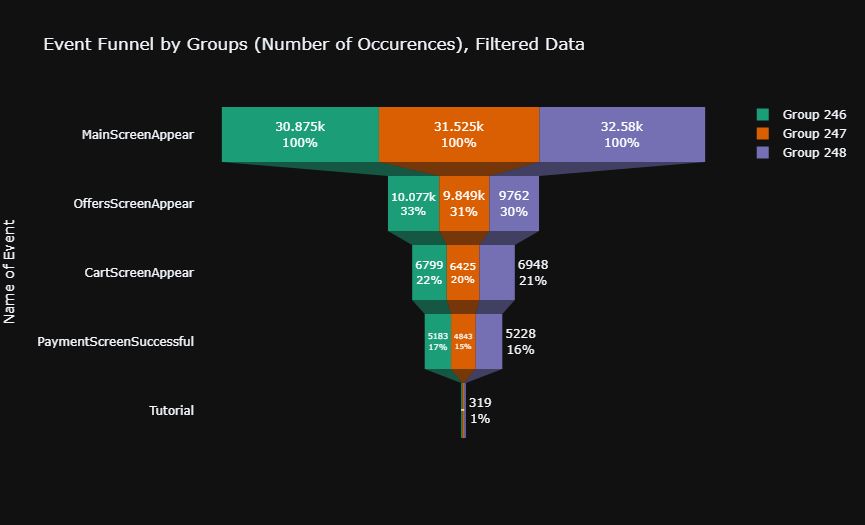

In [74]:
# re-making the funnel of actions for the filtered data.
event_users_filtered = logs_filtered.groupby('event_name').agg(
    number_of_users = ('user_id', 'nunique')
).sort_values(by = 'number_of_users', ascending = False).reset_index()

# adding another column, showing the percentage of the number of users who performed each action, 
# from the *total* amount of users.
event_users_filtered['percentage_from_total'] = (
    100 * (event_users_filtered['number_of_users'] /
           logs_filtered['user_id'].nunique())).round(decimals = 2)

event_users_filtered

,event_name,number_of_users,percentage_from_total
0,MainScreenAppear,6939,98.44
1,OffersScreenAppear,4128,58.56
2,CartScreenAppear,3283,46.57
3,PaymentScreenSuccessful,3095,43.91
4,Tutorial,761,10.80


In [ ]:
# visualizing the funnel(s)
# number of users funnel
fig = go.Figure(go.Funnel(
    y = event_users_filtered['event_name'],
    x = event_users_filtered['number_of_users'],
    textinfo = 'value + percent initial + percent previous'
))

fig.update_layout(title = 'General Event Funnel (Number of Users per Action), Filtered Data', 
                  font=dict(size=16))
fig.update_yaxes(title = 'Name of Event')

fig.show()

# percentage of users funnel
fig = go.Figure(go.Funnel(
    y = event_users_filtered['event_name'],
    x = event_users_filtered['percentage_from_total'],
))

fig.update_layout(title = 'General Event Funnel (% of Users From Total), Filtered Data', 
                  font=dict(size=16))
fig.update_yaxes(title = 'Name of Event')

fig.show()

![Plot%2012%20%28General%20Event%20Funnel%20(Number%20of%20Users%20per%20Action%29,%20Filtered%20Data).png](attachment:Plot%2012%20%28General%20Event%20Funnel%20(Number%20of%20Users%20per%20Action%29,%20Filtered%20Data).png)
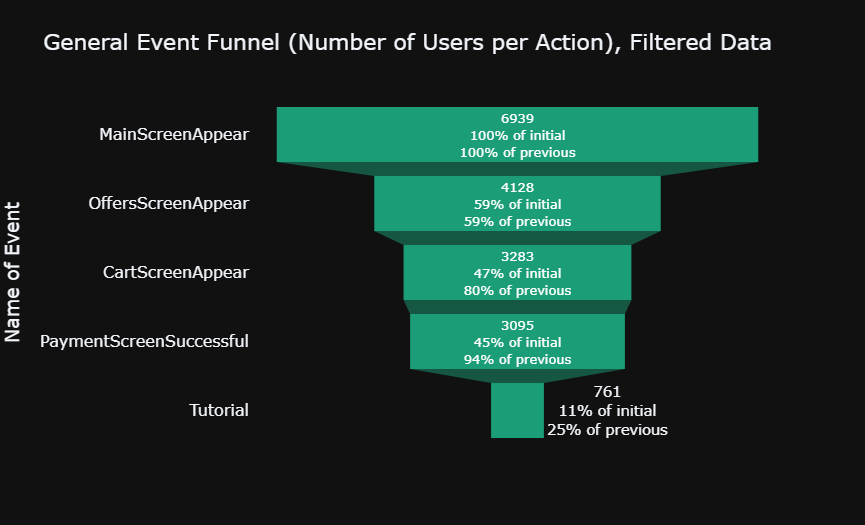

![Plot%2013%20%28General%20Event%20Funnel%20(%25%20of%20Users%20From%20Total%29,%20Filtered%20Data).png](attachment:Plot%2013%20%28General%20Event%20Funnel%20(%25%20of%20Users%20From%20Total%29,%20Filtered%20Data).png)
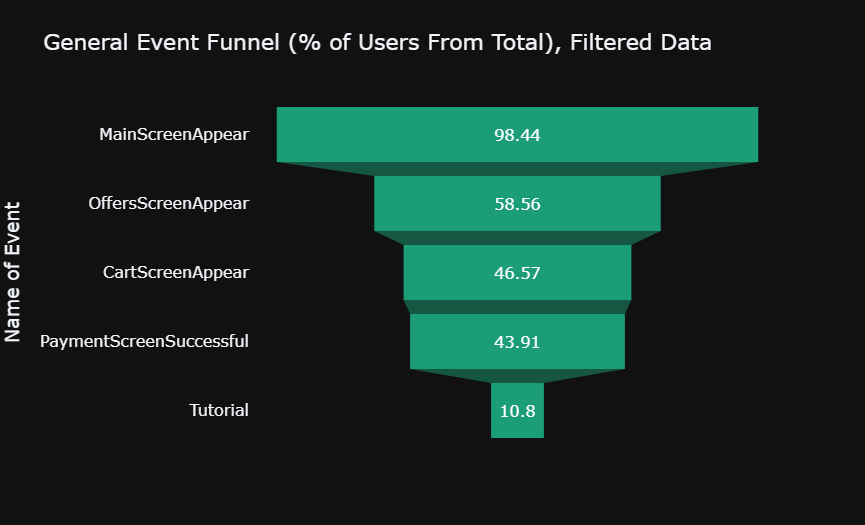

In [76]:
# re-making the group funnels, with the filtered data. This is the table we will use for the testing.
event_users_groups_filtered = logs_filtered.groupby(['event_name', 'group_id']).agg(
    number_of_users = ('user_id', 'nunique')
).sort_values(by = ['group_id', 'number_of_users'], ascending = [True, False]).reset_index()

# adding another column, showing the percentage of the number of users who performed each action, 
# from the *total* amount of users in each group.
# we'll have to define a dictionary for each group's total number of users, first.
group_dict = {246: logs_filtered.query('group_id == 246')['user_id'].nunique(),
              247: logs_filtered.query('group_id == 247')['user_id'].nunique(),
              248: logs_filtered.query('group_id == 248')['user_id'].nunique()}

event_users_groups_filtered['percentage_from_group'] = ( 
    100 * (event_users_groups_filtered['number_of_users'] /
           event_users_groups_filtered['group_id'].map(group_dict))).round(decimals = 2)

event_users_groups_filtered

,event_name,group_id,number_of_users,percentage_from_group
0,MainScreenAppear,246,2296,98.58
1,OffersScreenAppear,246,1392,59.77
2,CartScreenAppear,246,1120,48.09
3,PaymentScreenSuccessful,246,1056,45.34
4,Tutorial,246,248,10.65
5,MainScreenAppear,247,2319,98.51
6,OffersScreenAppear,247,1367,58.07
7,CartScreenAppear,247,1090,46.30
8,PaymentScreenSuccessful,247,1012,42.99
9,Tutorial,247,261,11.09


In [ ]:
# plotting the funnels for the filtered data.
# number of users per action funnel
fig = go.Figure(go.Funnel(
    name = 'Group 246',
    y = event_users_groups_filtered[event_users_groups_filtered['group_id']==246]['event_name'],
    x = event_users_groups_filtered[event_users_groups_filtered['group_id']==246]['number_of_users'],
    textinfo = 'value + percent initial + percent previous'))

fig.add_trace(go.Funnel(
    name = 'Group 247',
    y = event_users_groups_filtered[event_users_groups_filtered['group_id']==247]['event_name'],
    x = event_users_groups_filtered[event_users_groups_filtered['group_id']==247]['number_of_users'],
    textinfo = 'value + percent initial + percent previous'))

fig.add_trace(go.Funnel(
    name = 'Group 248',
    y = event_users_groups_filtered[event_users_groups_filtered['group_id']==248]['event_name'],
    x = event_users_groups_filtered[event_users_groups_filtered['group_id']==248]['number_of_users'],
    textinfo = 'value + percent initial + percent previous'))

fig.update_layout(title = 'Group Event Funnel (Number of Users per Action, Filtered Data)')
fig.update_yaxes(title = 'Name of Event')

fig.show()

# percentage of group users funnel
fig = go.Figure(go.Funnel(
    name = 'Group 246',
    y = event_users_groups_filtered[event_users_groups_filtered['group_id']==246]['event_name'],
    x = event_users_groups_filtered[event_users_groups_filtered['group_id']==246]['percentage_from_group'],
))

fig.add_trace(go.Funnel(
    name = 'Group 247',
    y = event_users_groups_filtered[event_users_groups_filtered['group_id']==247]['event_name'],
    x = event_users_groups_filtered[event_users_groups_filtered['group_id']==247]['percentage_from_group'],
))

fig.add_trace(go.Funnel(
    name = 'Group 248',
    y = event_users_groups_filtered[event_users_groups_filtered['group_id']==248]['event_name'],
    x = event_users_groups_filtered[event_users_groups_filtered['group_id']==248]['percentage_from_group'],
))

fig.update_layout(title = 'Group Event Funnel (% of Users From Group), Filtered Data')
fig.update_yaxes(title = 'Name of Event')

fig.show()

![Plot%2014%20%28Group%20Event%20Funnel%20(Number%20of%20Users%20per%20Action,%20Filtered%20Data%29).png](attachment:Plot%2014%20%28Group%20Event%20Funnel%20(Number%20of%20Users%20per%20Action,%20Filtered%20Data%29).png)
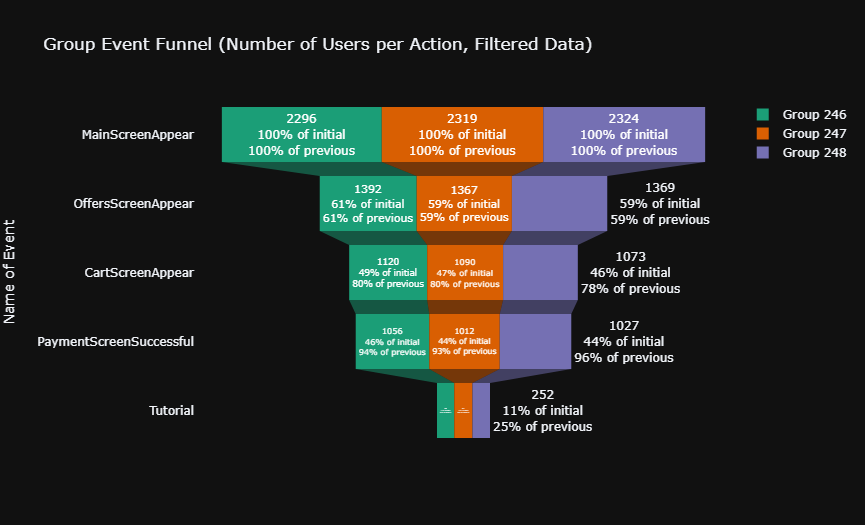

![Plot%2015%20%28Group%20Event%20Funnel%20(%25%20of%20Users%20From%20Group%29,%20Filtered%20Data).png](attachment:Plot%2015%20%28Group%20Event%20Funnel%20(%25%20of%20Users%20From%20Group%29,%20Filtered%20Data).png)
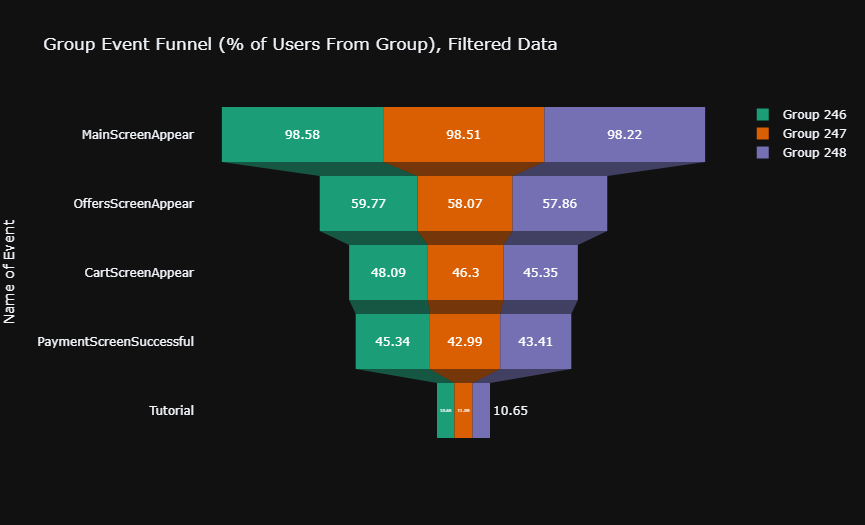

In [78]:
users_filtered = {'group_id': [246, 247, 248], 
                  'users': [logs_filtered.query('group_id == 246')['user_id'].nunique(), 
                            logs_filtered.query('group_id == 247')['user_id'].nunique(), 
                            logs_filtered.query('group_id == 248')['user_id'].nunique()]}
users_table_filtered = pd.DataFrame(data=users_filtered)

# recalculating group 249
group249_users_filtered = (int(users_table_filtered.query('group_id == 246')['users']) + 
                           int(users_table_filtered.query('group_id == 247')['users']))
group249_row_filtered = pd.DataFrame(data = {'group_id': [249], 'users': [group249_users_filtered]})

users_table_filtered = pd.concat([users_table_filtered, group249_row_filtered]).reset_index(drop = True)

users_table_filtered

,group_id,users
0,246,2329
1,247,2354
2,248,2366
3,249,4683


In [79]:
# updating the `event_users_groups_filtered` table with group 249.

# slice the groups to be combined from `event_users_groups_filtered`
group246_filtered = event_users_groups_filtered.query('group_id == 246')
group247_filtered = event_users_groups_filtered.query('group_id == 247')

# make a copy of the dataframe (because it has the structure we need), we'll edit the columns in a bit
group249_filtered = group246_filtered.copy()

# edit the group id, change it to 249
group249_filtered['group_id'] = 249

# sum the corresponding values in the `number_of_users` column of groups 246 and 247, 
# and put the results in that column for group 249
group249_filtered['number_of_users'] = group246_filtered['number_of_users'].add(
    group247_filtered['number_of_users'], fill_value = group247_filtered['number_of_users'])

# changing datatype, the above line results in float.
group249_filtered['number_of_users'] = group249_filtered['number_of_users'].astype('int64')

# fixing the `percentage_from_group` column values accordingly.
group249_filtered['percentage_from_group'] = (
    100 * group249_filtered['number_of_users'] / 
    int(users_table_filtered.query('group_id == 249')['users'])).round(decimals = 2)

# checking the result
group249_filtered

,event_name,group_id,number_of_users,percentage_from_group
0,MainScreenAppear,249,4615,98.55
1,OffersScreenAppear,249,2759,58.92
2,CartScreenAppear,249,2210,47.19
3,PaymentScreenSuccessful,249,2068,44.16
4,Tutorial,249,509,10.87


In [80]:
# adding the above table to the `event_users_groups_filtered`
event_users_groups_filtered = pd.concat([event_users_groups_filtered, group249_filtered])

In [81]:
# cleaning up a little
event_users_groups_filtered = event_users_groups_filtered.sort_values(
    by = ['group_id', 'number_of_users'], ascending = [True, False]).reset_index(drop = True)

# checking the result
event_users_groups_filtered

,event_name,group_id,number_of_users,percentage_from_group
0,MainScreenAppear,246,2296,98.58
1,OffersScreenAppear,246,1392,59.77
2,CartScreenAppear,246,1120,48.09
3,PaymentScreenSuccessful,246,1056,45.34
4,Tutorial,246,248,10.65
5,MainScreenAppear,247,2319,98.51
6,OffersScreenAppear,247,1367,58.07
7,CartScreenAppear,247,1090,46.30
8,PaymentScreenSuccessful,247,1012,42.99
9,Tutorial,247,261,11.09


In [82]:
# updating the function for the Z-test, so it would take values from the correct tables.
def check_zvalue_filtered (group1: int, group2: int, event: str, alpha_value: float):
    
    print ('Compared groups:', group1, 'and', group2, '.', 'Event in question:', event)
    print ()
    
    trials1 = int(users_table_filtered[users_table_filtered['group_id']==group1]['users'])
    trials2 = int(users_table_filtered[users_table_filtered['group_id']==group2]['users'])
    
    successes1 = int(event_users_groups_filtered[
        (event_users_groups_filtered['group_id'] == group1) & 
        (event_users_groups_filtered['event_name'] == event)]['number_of_users'])
    successes2 = int(event_users_groups_filtered[
        (event_users_groups_filtered['group_id'] == group2) &
        (event_users_groups_filtered['event_name'] == event)]['number_of_users'])
    
    print ('Total users in group', group1, "-", trials1)
    print ('total of users who performed the event -', successes1)
    print ('Proportion in the group: {:.2%}'.format(successes1/trials1))
    print ()
    print ('Total users in group', group2, "-", trials2)
    print ('total of users who performed the event -', successes2)
    print ('Proportion in the group: {:.2%}'.format(successes2/trials2))
    print ()
    
    alpha = alpha_value
    stat, p_value = proportions_ztest([successes1, successes2], [trials1 ,trials2])
    
    print ('Z-test results:')
    print ('p-value: {:.5f}'.format(p_value))
    print ('alpha value:', alpha)
    if p_value < alpha:
        print ('Null hypothesis rejected - the proportions are significantly different')
    else:
        print ('Failed to reject null hypothesis - there is no reason to consider the proportions different')
    
    print ('-------------------------------------------------------------------------------------------')

We've come a long way. Now we will repeat all 16 Z-tests (including the A/A test), this time using the reduced corrected alpha value (0.05/16), as we are using the same population for all 16 tests. Our expectation is that, just like with the outlier-including data, we will fail to reject all null hypotheses.

In [83]:
for event in event_list:
    check_zvalue_filtered(246, 247, event, 0.05/16)
for event in event_list:
    check_zvalue_filtered(246, 248, event, 0.05/16)
for event in event_list:
    check_zvalue_filtered(247, 248, event, 0.05/16)
for event in event_list:
    check_zvalue_filtered(249, 248, event, 0.05/16)

Compared groups: 246 and 247 . Event in question: MainScreenAppear

Total users in group 246 - 2329
total of users who performed the event - 2296
Proportion in the group: 98.58%

Total users in group 247 - 2354
total of users who performed the event - 2319
Proportion in the group: 98.51%

Z-test results:
p-value: 0.84150
alpha value: 0.003125
Failed to reject null hypothesis - there is no reason to consider the proportions different
-------------------------------------------------------------------------------------------
Compared groups: 246 and 247 . Event in question: OffersScreenAppear

Total users in group 246 - 2329
total of users who performed the event - 1392
Proportion in the group: 59.77%

Total users in group 247 - 2354
total of users who performed the event - 1367
Proportion in the group: 58.07%

Z-test results:
p-value: 0.23799
alpha value: 0.003125
Failed to reject null hypothesis - there is no reason to consider the proportions different
--------------------------------

Just as expected - we have failed to reject all null hypotheses. This is, again, probably due to the fact that it doesn't matter if we have users with many actions in our data, if our testing methodology only "cares" about whether a given user performed any kind of action at least once, and "doesn't care" even if they did it 1000 times. 

In the end, all we did now was just shrink the population of all three tests groups in more or less the same margin, and take out a certain amount of users who surely have performed all four types of events (given the amount of their actions - what's the chance that any of those users only had 3 types of events, or even less? highly unlikely). Of course it affects the p-values of the test a little, but not enough to make any major difference.

It is worthy to mention that the same test that yielded a p-value between 0.05 and 0.1 before (groups 246 and 248, test for CartScreenAppear), did so AGAIN with the filtered data, and while it did come closer to 0.05, it still wasn't lower than that. That is to say that even if we would have used `alpha = 0.05` in the filtered data tests, we would still not be able to reject ANY of the null hypotheses.

In other words - **with the the outlier users or without them**, the control groups and test groups can be considered similar. The differences between them are very very small, that is to say, not statistically significant.

# Final Conclusions

The startup's desire to boost its revenue by simply changing the font set used in its app has turned down to be ineffective. After conducting a week-long A/A/B test, which involved two control groups and one test group (the latter using the app with the new fonts) it turned out that the user behaviour accross all three groups was statistically similar, with only minor, insignificant differences. That is why the recommendation is for the test to be stopped (if it hasn't already), and either retain the old font set or use the new one - it doesn't make any difference.

Studying the event funnels of the entire population of the test, as well as that of each group separately, revealed a similar picture. An important conclusion to be learned from the study - unrelated to which font is used - is that roughly 75% of the users who view and offers page, also make a purchase (this alone could be considered great news). The problem is, however, than only about 62% of users who view the main screen of the app even proceed to viewing an offers page. If anything is to be learned from this experiment, other than the fact that users "don't give a font", is that something in the main screen has to be changed, because it is this stage in which the company loses most users - the retention rate going from the main screen to the offers screen is only 62%, whereas it is higher in all subsequent steps. This might be a simple matter of UI/UX design.